# Introduction to Generaticve Adversarial Networks!

### Review: AutoEncoders
We have seen previously that AutoEncoders can be used to generate images. In the setup for the [AutoEncoder](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Intro_To_AutoEncoders.ipynb), we first train an Encoder that learns to compress an image down to some latent, and then a decoder, that learns to take that latent and reconstruct the original image. The outputs of the encoder can be used to study the high dimensional structure of the data, and we typically don't care about the decoder unless we want to do a generative task!

If we only use our decoder, we can pass in latents to it, and it will generate images on the other end! Unfortunately this can be tough as the structure of the latent space can be unknown, although we do solve this partially through placing a KL penalty in the [Variational AutoEncoder](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Variational_AutoEncoders.ipynb) to ensure normality. 

Unfortunately, the VAE does suffer from one issue: Poor Image Quality! Here is an example of all of the outputs of our autoencoders on the MNIST dataset:
![image](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/all_vae_gens_on_digit.png?raw=true)

As it can be clearly seen, these would not be considered very high quality generations of handwritten digits. They are typically blurry, and using a VAE, which is the only way to generate from a known distribution, the results get even worse!

### What are GANs?

GANs are basically a cat and mouse game, and changes the way in which we approach generation. Instead of an Encoder/Decoder structure of the AutoEncoder, we will have a Generator and Discriminator. The purpose of the Generator is to take in noise (typically random gaussian noise) and try to create an image out of it. This method of generating from noise is a technique we will see again in the future with Diffusion! The Discriminator on the other hand takes in generated images and real images from our dataset, and tries to determine whether or not each image is real or fake. The game then becomes: The Generator has to produce images that can fool the Discriminator, which then forces the Discriminator to become better at identifying real and fake images!

### The Math for GANs 

Lets go through this step by step!

#### Training the Discriminator

The first step will be to take our random noise and use or Generator $G(z)$ to generate a batch of fake samples. We can then concatenate our fake samples to real ones to create a batch where half the images are real and the other half are fake. We can similarly create labels for this, identifying which images are real and which are fake (we will use 0 for generated and 1 for true, although it doesn't matter which is which) and then give the discriminator this data to learn to identify real from fake images!

The Loss function we use in this case is the Binary Cross Entropy (BCE) Loss Function! 

$$H(y,\hat{y}) = -\frac{1}{N}\sum y\log(\hat{y}) + (1-y)\log(1-\hat{y})$$

*If you dont know where this came from, please take a look at my [video](https://www.youtube.com/watch?v=d86lJxKInYg&t=3931s) where we derive this!*

We know that in our case of binary (fake vs real) prediction, the y value can either be 0 or 1. When y is 1 (indicating a real image), the discriminator is seeing real images, lets call them $x$. In this case, the output of our discriminator will just be $\hat{y} = D(x)$, as the discriminator is getting true images. Then we get the following simplification of the BCE Loss:

$$H_{real}(y=1,\hat{y}) = -\frac{1}{N}\sum (1)\log(D(x)) + (1-1)\log(1-D(x)) = -\frac{1}{N}\sum \log(D(x))$$

Similarly when y is 0 (indicating a fake image) the discriminator is seeing the fake generated images $G(z)$. In this case the output of the discriminator will just be $\hat{y} = D(G(z))$ as the discriminator is getting fake images. Then we see the following simplification of the BCE Loss:

$$H_{fake}(y=0,\hat{y}) = -\frac{1}{N}\sum (0)\log(D(G(z))) + (1-0)\log(1-D(G(z))) = -\frac{1}{N}\sum \log(1-D(G(z)))$$

Therefore, our final Discriminator loss can be written out as the sum of the real and fake discriminator losses:

$$H_D = -\frac{1}{N}\sum \log(D(x)) + \log(1-D(G(z)))$$

#### Expanding to Continuous Distributions
Although this is the discriminator we use (because in our classification task our targets are discrete 0/1), it hides an underlying property we want to look at! Instead of just using 0/1 to indicate fake or real, lets instead say we want to model the continuous distribution of the fake images and the distribution of the real images. Applying it to our case, where $p_{x}$ is the true distribution of the data, $p_{z}$ is the true distribution of the random noise and then $D(x)$ is the predicted distribution of real data and $D(G(z))$ is the predicted distribution of the generated data. We can then write:

$$H_{real}(p_x(x), D(x)) = -\int p_x(x) \log(D(x))$$
$$H_{fake}(p_z(z), D(G(z))) = -\int p_z(z) \log((1-D(G(z))))$$

And our final continuous discriminator loss can be written as:
$$H_D = H_{real}(p_x(x), D(x)) + H_{fake}(p_z(z), D(G(z))) = -\int p_x(x) \log(D(x)) + p_z(z) \log((1-D(G(z))))$$

This should look identical to our equation earlier for the discriminator loss! Just a continuous representation. We can then finally convert this to just using expected value using the following method:

$$H(p,q) = \int p \log(q) = \mathbb{E}_{x\sim p} \log(q)$$

Therefore our final form (in expected value) of our Discriminator loss looks like:
$$H_D = -\mathbb{E}_{x\sim p_x(x)} \log(D(x)) -\mathbb{E}_{x\sim p_z(z)} \log((1-D(G(z))$$

Our end goal will be to minimize $H_D$, as you want the discriminator to get better at identifying fakes, but minimizing $H_D$ is the same as maximizing $-H_D$ (and we have those negatives we don't want to write) so we can write the final form of our discriminator loss as:

$$L_D = \max_D \mathbb{E}_{x\sim p_x(x)} \log(D(x)) +\mathbb{E}_{x\sim p_z(z)} \log((1-D(G(z)))$$

And finally, the most general form, lets say $x$ is now an arbritrary sample, we don't now if its real or generated, then we can write the most general form of our loss function using some variable substitutions:
$$L_D = \max_D \mathbb{E}_{x\sim p_{data}(x)} \log(D(x)) +\mathbb{E}_{x\sim p_g} \log((1-D(x))$$

where $p_g$ is the distribution of the generator (rather than over the distribution of the random noise) and $p_{data}$ is the distribution over the data (previously 
$p_{x}$)

#### Finding the Ideal Discriminator
To find the max of this function (the $D(x)$ that maximizes this $L_D$), we can just take the derivative of $L_D$ with respect to $D(x)$ and set to 0!

$$\dfrac{dL_D}{dD(x)} = \frac{p_{data}(x)}{D(x)} - \frac{p_g(x)}{1-D(x)} = 0$$

Solving for $D(x)$, and giving us our optimial discriminator, which we will indicate as $D^*(x)$ we get:

$$D^*(x) = \frac{p_{data}(x)}{p_{data}(x)+p_g(x)}$$

This also makes a lot of sense because, if $x$ is truly from the original true data, then this fraction will converge to 1 as $p_{data}(x)$ will be close to 1 and $p_g(x)$ will be close to 0. On the other hand, if $x$ is from the generated data, then this fraction will converge to 0.

### Training the Generator
So we have finally created a mechanism (using basic BCE Loss) to have our discriminator successfully be able to identify real from fake images! Now how do we use this information to actually train our generator? If we assume that our new discriminator $D^*(x)$ that was trained from the previous step can actually identify real from fake images, then we can use that information to inform our gradient update of the generator. In summary, the generators goal is to maximize the discriminators confusion about which images are real and which are fake!

As before, 0 is fake images and 1 is real images. In practice what we do is, take our generated images that have been produced by the generator and pass them through the discriminator, which will identify which are real and which are not (in this case all are fake because they are all generated). We will then pretend that all of the fake images we passed in were real, and give them all a label of 1. We can then compute the loss between what the discriminator predicted and them all being true images (even through they are fake). This information can finally be backpropagated to the generator to update its weight, towards the direction that convinces the discriminator that the images are real. 

#### SUPER IMPORTANT NOTE!!!
The key idea here is that the discriminator will provide a signal of real vs fake. When we backpropagate this signal to the generator (which is trying to fool the discriminator), we **ONLY UPDATE THE WEIGHTS OF THE GENERATOR**. The backpropagation (although will compute gradients on the discriminator) will not be used to actually update the discriminator (i.e. this step of updating the generator assumed a fixed discriminator)

#### Discrete Loss for the Generator
As explained above, the idea generator will minimize the discriminators ability to distinguish between real and fake samples, and we assume we are using our new discriminator $D^*(x)$. Well this loss function is identical again to before, just a simple BCELoss, so lets do the discrete case first (that we will actually use in practice). All images will be identified as real where $y=1$ so in our BCE Loss, the case of $(1-y)$ will dissapear:

$$H(y,\hat{y}) = -\frac{1}{N}\sum y\log(\hat{y}) + (1-y)\log(1-\hat{y})$$
$$H(y=1,\hat{y}) = -\frac{1}{N}\sum (1)\log(\hat{y}) + (1-1)\log(1-\hat{y}) = -\frac{1}{N}\sum \log(\hat{y})$$

So in our case, where $\hat{y} = D^*(G(z))$ because we are using generated images, we can write this as: 
$$H(y=1,\hat{y}) = - \frac{1}{N}\sum \log(D^*(G(z)))$$

#### Moving to the Continuous Loss Function
Using all the same logic as before, when we expanded our discrete discriminator loss to continuous, we can do the same process here. $x$ is again some arbritrary image, although we know they are all fake, the loss doesn't! 

$$L_G = \min_G \mathbb{E}_{x\sim p_{data}(x)} \log(D^*(x)) +\mathbb{E}_{x\sim p_g} \log((1-D^*(x))$$

There are two main differences between our generator loss $L_G$ and our discriminator loss $L_D$:

1) We are using a static $D^*(x)$ already computed from the previous step
2) We are minimizing w.r.t. G!. We want our discriminator to maximize log probabilities, getting better at identifying real vs fake images, but our generator will minimze the same log probailities, updating the generator weights in the direction that most fools the discriminator!

Now, because we actually know what the formulation for the ideal discriminator $D^*(x)$ is, we can plug it in!

$$L_G = \min_G \mathbb{E}_{x\sim p_{data}(x)} \log(D^*(x)) +\mathbb{E}_{x\sim p_g} \log((1-D^*(x))$$

$$ = \min_G \mathbb{E}_{x\sim p_{data}(x)} \log\left[\frac{p_{data}(x)}{p_{data}(x)+p_g(x)}\right] +\mathbb{E}_{x\sim p_g} \log\left[1 - \frac{p_{data}(x)}{p_{data}(x)+p_g(x)}\right]$$

$$ = \min_G \mathbb{E}_{x\sim p_{data}(x)} \log\left[\frac{p_{data}(x)}{p_{data}(x)+p_g(x)}\right] +\mathbb{E}_{x\sim p_g} \log\left[\frac{p_{g}(x)}{p_{data}(x)+p_g(x)}\right]$$

#### Quick Aside: Relation to Jensen-Shannon Divergence
So we have already seek KL-Divergence before (if you haven't take a look at my [notebook on Variational AutoEncoders](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Variational_AutoEncoders.ipynb) to learn more and also this [helpful video] walking you through the relation between KL divergence and Cross Entropy. As a quick reminder though:

KL Divergence is a measure of entropy (or difference) between two probability distributions. But what is Entropy? Entropy is a measure of the amount of "information" in data and is typically written as:,
$$H = -\sum_{i=1}^Np(x_i)\cdot \log p(x_i)$$
You can think of this like the Expected Value of information in an event. KL Divergence is then the difference in information between two separate distributions $P$ and $Q$. Well then we can just write that as:
$$D_{KL}(Q||P) = \sum_{i=1}^Np(x_i) \cdot (\log p(x_i) - \log q(x_i)) = \sum_{i=1}^Np(x_i) \cdot \log \frac{p(x_i)}{q(x_i)} = \mathbb{E}_{x\sim p} \log\frac{p(x)}{q(x)}$$

Well, doesnt our form for $L_G$ look like the sum of two different KL-Divergence terms? We could rewrite it as such:

$$L_G = D_{KL}(p_{data}(x) || p_{data}(x)+p_g(x)) + D_{KL}(p_{g}(x) || p_{data}(x)+p_g(x))$$

If thats the case, we know of another formulation that looks just like this: **Jensen-Shannon Divergence**

$$D_{JS}(Q||P) = \frac{1}{2}D_{KL}(Q||M) + \frac{1}{2}D_{KL}(P||M)$$ 

$$\text{where } M = \frac{Q+P}{2}$$

Although KL-Divergences are very useful to us, it has a few limitations, notably not being symmetric. $D_{KL}(Q||P) \neq D_{KL}(P||Q)$. JS-Divergence on the other hand is a symmetric and smooth version of the KL divergence, and $M$ is the mixture of distributions P and Q.

In our case, we have something very similar in $L_G$, but we are missing a few of those $\frac{1}{2}$ constants, so lets expand it out. First we use the rule that $\log(\frac{a}{b})= \log(a) - \log(b)$

$$ \mathbb{E}_{x\sim p_{data}(x)} \log\left[\frac{p_{data}(x)}{p_{data}(x)+p_g(x)}\right] +\mathbb{E}_{x\sim p_g} \log\left[\frac{p_{g}(x)}{p_{data}(x)+p_g(x)}\right]$$

$$ = \mathbb{E}_{x\sim p_{data}(x)} \left[\log p_{data}(x) - \log (p_{data}(x)+p_g(x))\right] +\mathbb{E}_{x\sim p_g} \left[\log p_{g}(x) - \log (p_{data}(x)+p_g(x))\right]$$

We first know that:
$$M(x) = \frac{p_{data}(x)+p_g(x)}{2}$$

So lets introduce the $\frac{1}{2}$ constant by multiplying and dividing by 2!

$$ = \mathbb{E}_{x\sim p_{data}(x)} \left[\log p_{data}(x) - \log \frac{2(p_{data}(x)+p_g(x))}{2}\right] +\mathbb{E}_{x\sim p_g} \left[\log p_{g}(x) - \log \frac{2(p_{data}(x)+p_g(x))}{2}\right]$$

$$ = \mathbb{E}_{x\sim p_{data}(x)} \left[\log p_{data}(x) - \log(2) - \log \frac{(p_{data}(x)+p_g(x))}{2}\right] +\mathbb{E}_{x\sim p_g} \left[\log p_{g}(x) - \log(2) - \log \frac{(p_{data}(x)+p_g(x))}{2}\right]$$

The expectation of the constant $\log(2)$ is just the constant, so we can pull them out!

$$ = -2\log(2) + \mathbb{E}_{x\sim p_{data}(x)} \left[\log p_{data}(x) - \log \frac{(p_{data}(x)+p_g(x))}{2}\right] +\mathbb{E}_{x\sim p_g} \left[\log p_{g}(x) - \log \frac{(p_{data}(x)+p_g(x))}{2}\right]$$

And finally we can return the expected values back to the original form (putting the logs back together)

$$ = -2\log(2) + \mathbb{E}_{x\sim p_{data}(x)} \left[\log \frac{p_{data}(x)}{\frac{(p_{data}(x)+p_g(x))}{2}}\right] +\mathbb{E}_{x\sim p_g} \left[\log \frac{p_{g}(x)}{\frac{(p_{data}(x)+p_g(x))}{2}}\right]$$

$$ = -2\log(2) + \mathbb{E}_{x\sim p_{data}(x)} \left[\log \frac{p_{data}(x)}{M(x)}\right] +\mathbb{E}_{x\sim p_g} \left[\log \frac{p_{g}(x)}{M(x)}\right]$$

We can write this all as the KL Divergences again:

$$ = -2\log(2) + D_{KL}(p_{data}(x) || M(x)) + D_{KL}(p_{g}(x) || M(x))$$

We are missing the last $\frac{1}{2}$ term, as we average together both KL Divergences, so we can just say that:

$$ = -2\log(2) + 2 * \frac{D_{KL}(p_{data}(x) || M(x)) + D_{KL}(p_{g}(x) || M(x))}{2}$$
$$ = -2\log(2) + 2 * D_{JS}(p_{data} || p_g)$$

This also makes a lot of sense. We will be minimizing this function for the generator, which will reduce the symmetric distance between $p_data$ and $p_g$. This means as the generator improves, the distribution of the generator will get closer to that of the original data, indicating a good generative model. 

### Final Loss Function
$$Loss = \min_G \max_D \mathbb{E}_{x\sim p_x(x)} \log(D(x)) +\mathbb{E}_{x\sim p_z(z)} \log((1-D(G(z)))$$

This is the original loss function for the GAN, and it does exactly what we have outlined until now. We will be maximizing $D$ and minimizing $G$. Notice we have a negative on our cross entropy, so instead of minimizing cross entropy we are maximizing negative cross entropy with $D$, if we had the normal cross entropy formula, then the min/max would be flipped but give the same result!

Our goal is to simulteously train a discriminator that maximizes this loss, which in effect maximizes the log-probability and makes a confident discriminator, and also minimize this loss by training a generator that can confidently fool the discriminator. 


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim 

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
class MNISTGenerator(nn.Module):
    def __init__(self, latent_dimension):
        super().__init__()

        self.generator = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, noise):
        batch_size = noise.shape[0]
        generated = self.generator(noise)
        return generated.reshape(batch_size, 1, 28, 28)

class MNISTDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(256, 1), # outputs logits
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        return self.discriminator(x)
        

In [3]:
latent_dimension = 100
batch_size = 128
generator_learning_rate = 0.0002
discriminator_learning_rate = 0.0002
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 200

In [4]:
### Define Models ###
generator = MNISTGenerator(latent_dimension).to(device)
discriminator = MNISTDiscriminator().to(device)

### Define Optimizers ###
gen_optimizer = optim.Adam(generator.parameters(), generator_learning_rate)
disc_optimizer = optim.Adam(discriminator.parameters(), discriminator_learning_rate)

### Define Datasets ###
tensor2image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


trainset = MNIST("../../data", transform=tensor2image_transforms)
trainloader = DataLoader(trainset, batch_size=batch_size)

### Define Loss Function ###
loss_func = nn.BCEWithLogitsLoss()

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0/200 | Generator Loss: 2.630125855776801 | Discriminator Loss: 0.39022921606787103


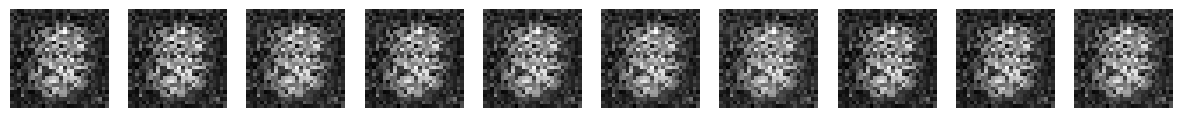

Epoch: 1/200 | Generator Loss: 4.094903814640126 | Discriminator Loss: 0.22548160160820224


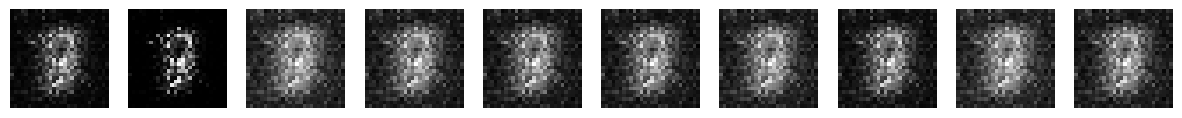

Epoch: 2/200 | Generator Loss: 3.7885739818564863 | Discriminator Loss: 0.08957484478889498


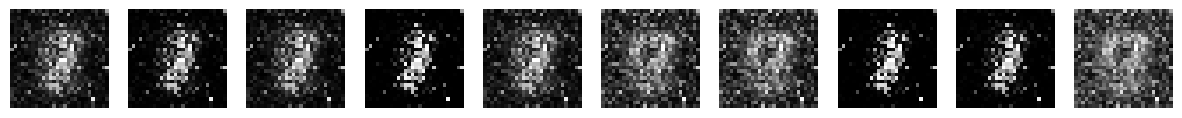

Epoch: 3/200 | Generator Loss: 5.390100568088133 | Discriminator Loss: 0.06449847499619542


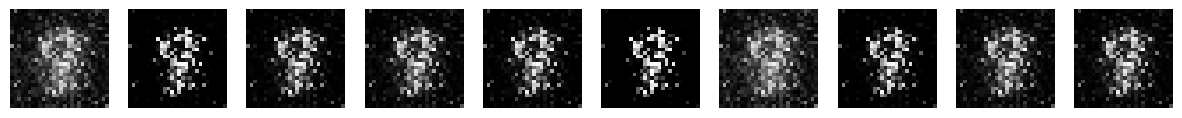

Epoch: 4/200 | Generator Loss: 6.024915092789542 | Discriminator Loss: 0.052505878940113444


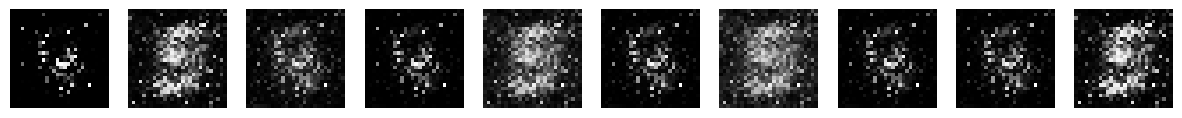

Epoch: 5/200 | Generator Loss: 5.250704067856518 | Discriminator Loss: 0.07086838509238112


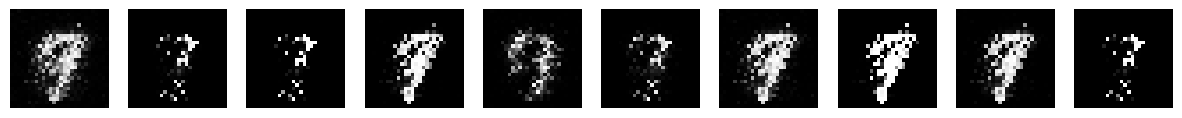

Epoch: 6/200 | Generator Loss: 5.464900925215374 | Discriminator Loss: 0.06236979253053951


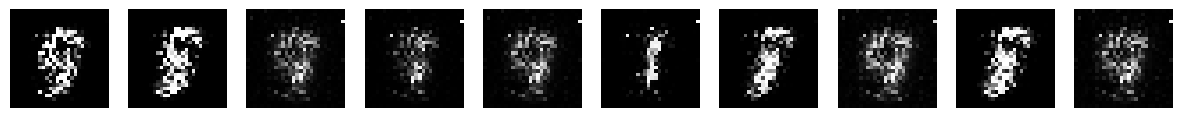

Epoch: 7/200 | Generator Loss: 4.699982305579602 | Discriminator Loss: 0.09309381401456242


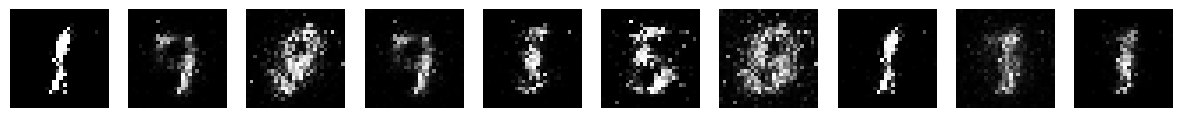

Epoch: 8/200 | Generator Loss: 4.360964138624765 | Discriminator Loss: 0.10695886823620751


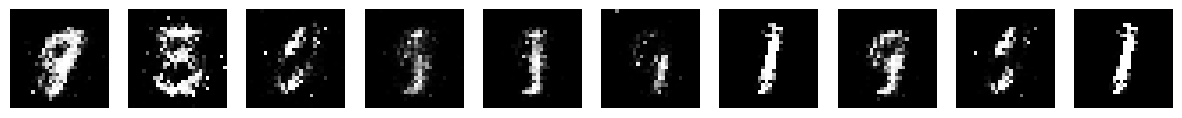

Epoch: 9/200 | Generator Loss: 3.903883585289343 | Discriminator Loss: 0.1361815287614428


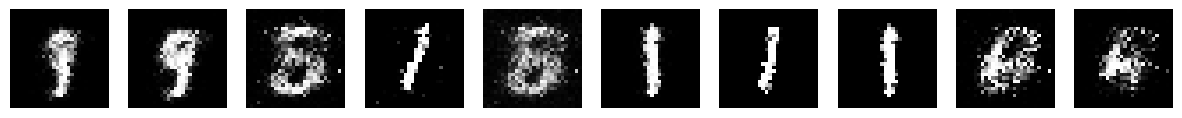

Epoch: 10/200 | Generator Loss: 3.7512887698500905 | Discriminator Loss: 0.13930274236367454


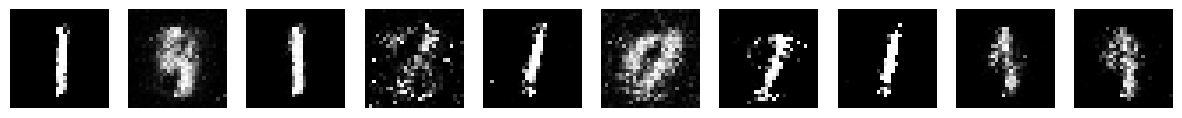

Epoch: 11/200 | Generator Loss: 3.207684413710637 | Discriminator Loss: 0.17123695358093868


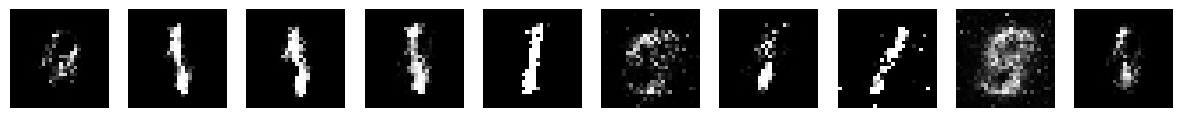

Epoch: 12/200 | Generator Loss: 2.9241300068938654 | Discriminator Loss: 0.2010105800018636


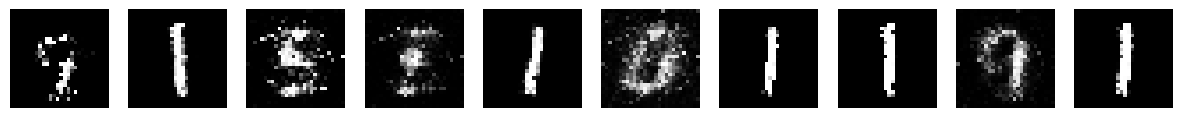

Epoch: 13/200 | Generator Loss: 2.7315449795997475 | Discriminator Loss: 0.21024026359512862


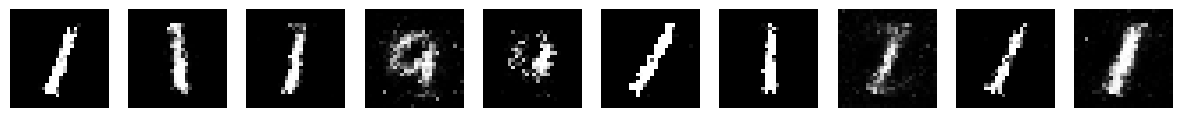

Epoch: 14/200 | Generator Loss: 2.6866923367290863 | Discriminator Loss: 0.21796328950919577


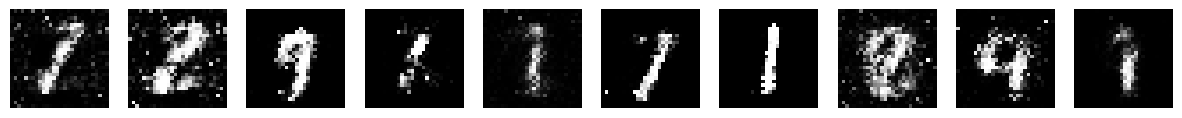

Epoch: 15/200 | Generator Loss: 2.564098602164783 | Discriminator Loss: 0.23306074220615663


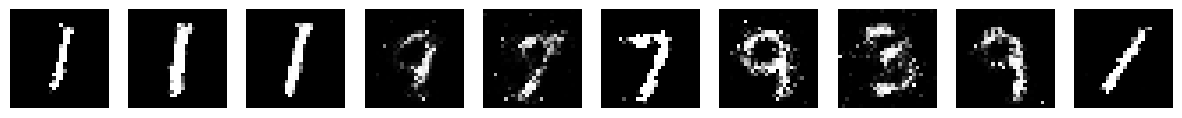

Epoch: 16/200 | Generator Loss: 2.4333206097454405 | Discriminator Loss: 0.2509590471540687


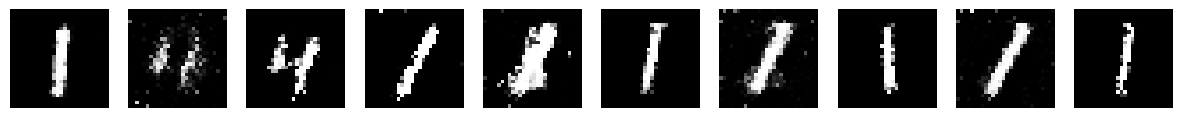

Epoch: 17/200 | Generator Loss: 2.333277496447695 | Discriminator Loss: 0.26169240948106687


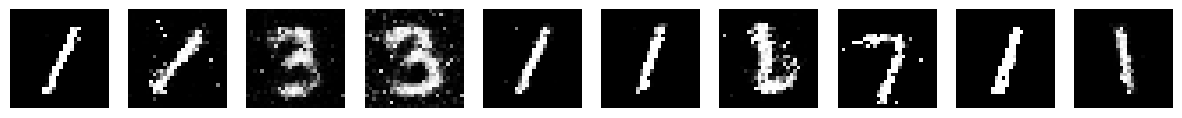

Epoch: 18/200 | Generator Loss: 2.2379698321255033 | Discriminator Loss: 0.2896404481455207


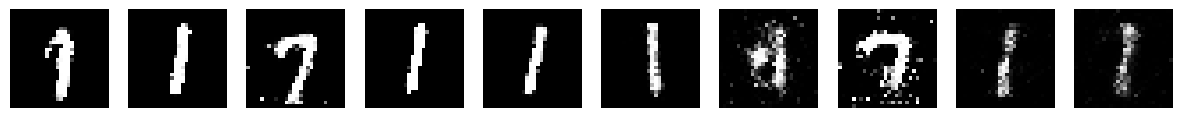

Epoch: 19/200 | Generator Loss: 2.090666052120835 | Discriminator Loss: 0.2980404913997345


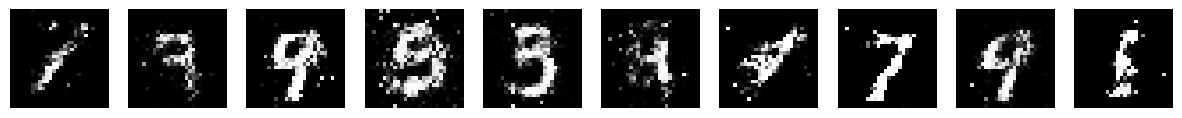

Epoch: 20/200 | Generator Loss: 2.0646400865969627 | Discriminator Loss: 0.32085654759076615


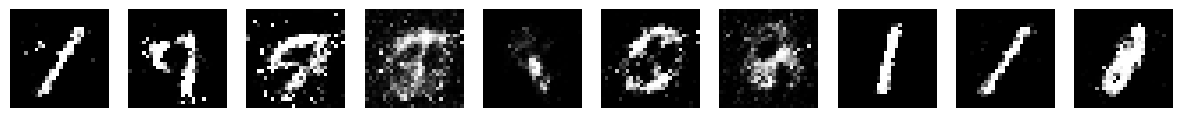

Epoch: 21/200 | Generator Loss: 1.9988658723038142 | Discriminator Loss: 0.3346668580956042


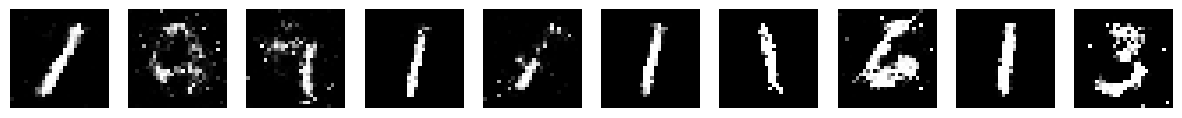

Epoch: 22/200 | Generator Loss: 2.010918659442015 | Discriminator Loss: 0.3326826331013047


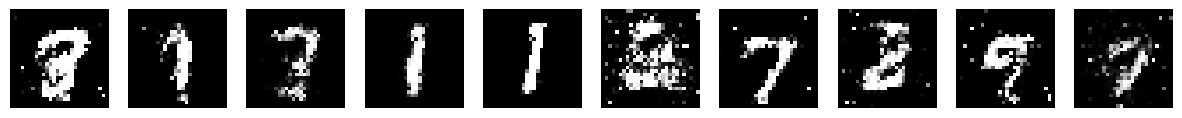

Epoch: 23/200 | Generator Loss: 1.952566889557503 | Discriminator Loss: 0.3499866410422681


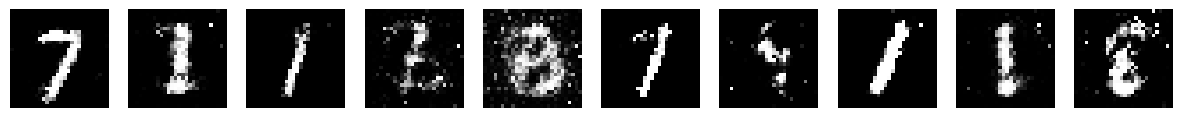

Epoch: 24/200 | Generator Loss: 1.8432978864417655 | Discriminator Loss: 0.37232842971521146


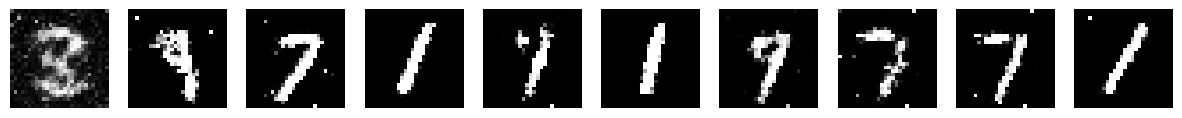

Epoch: 25/200 | Generator Loss: 1.7873548248937643 | Discriminator Loss: 0.37496883928902874


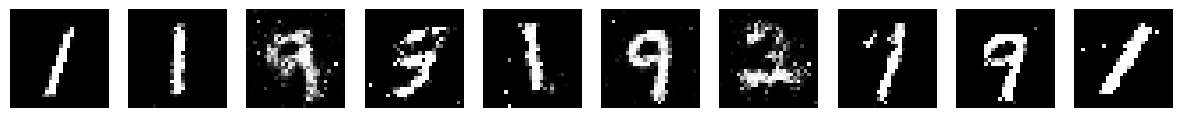

Epoch: 26/200 | Generator Loss: 1.7607453309142513 | Discriminator Loss: 0.38545831402481745


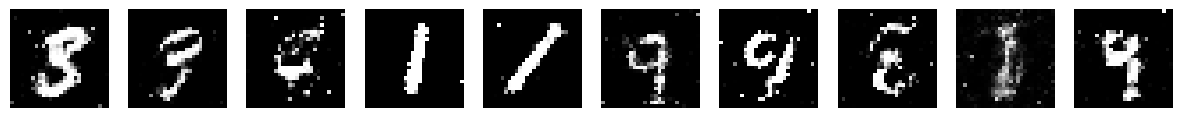

Epoch: 27/200 | Generator Loss: 1.7224275331253183 | Discriminator Loss: 0.39565471227743476


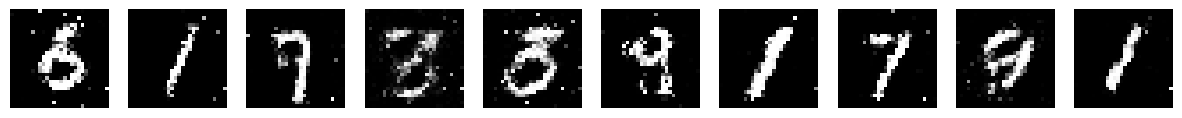

Epoch: 28/200 | Generator Loss: 1.6963003970412558 | Discriminator Loss: 0.3995778200341694


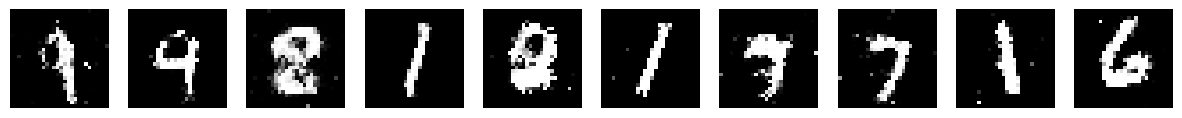

Epoch: 29/200 | Generator Loss: 1.622630876010415 | Discriminator Loss: 0.4207045521054949


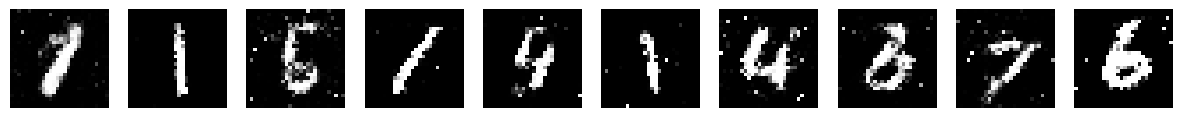

Epoch: 30/200 | Generator Loss: 1.5638317367923793 | Discriminator Loss: 0.4381248187790039


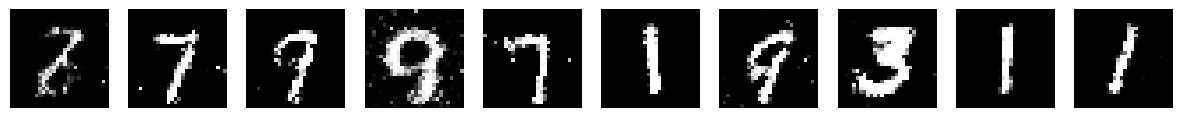

Epoch: 31/200 | Generator Loss: 1.5228744226732234 | Discriminator Loss: 0.44225125704238666


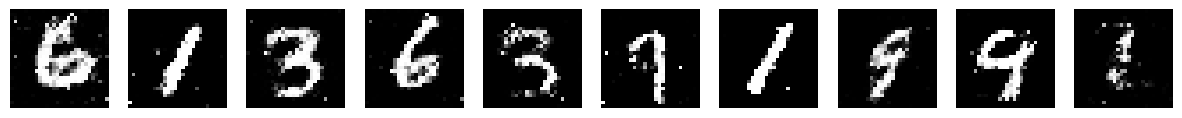

Epoch: 32/200 | Generator Loss: 1.5138610423500858 | Discriminator Loss: 0.44724910447338245


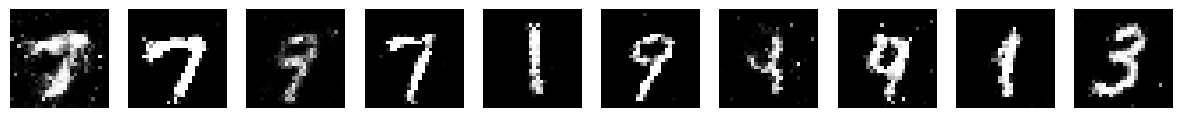

Epoch: 33/200 | Generator Loss: 1.4579971141652512 | Discriminator Loss: 0.4542673140573603


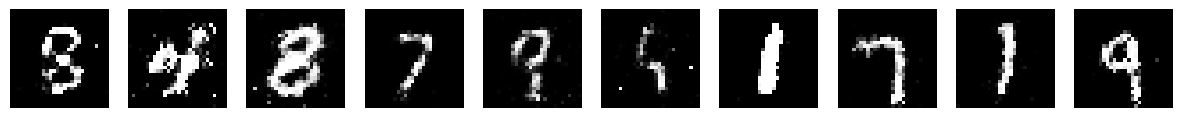

Epoch: 34/200 | Generator Loss: 1.4405981246342283 | Discriminator Loss: 0.45998036003570314


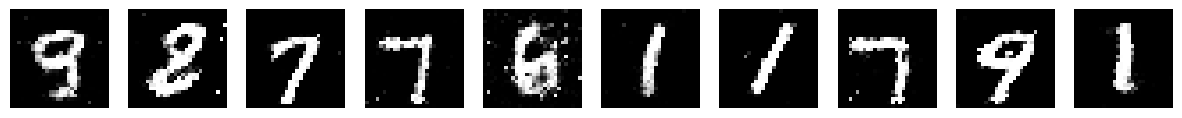

Epoch: 35/200 | Generator Loss: 1.4547994365570134 | Discriminator Loss: 0.46370256785899083


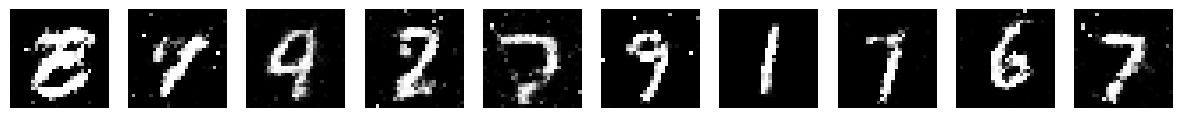

Epoch: 36/200 | Generator Loss: 1.4452691436576437 | Discriminator Loss: 0.46361125856320234


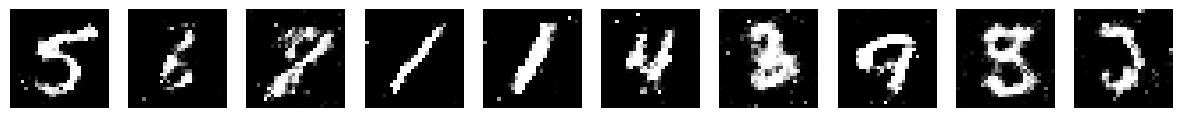

Epoch: 37/200 | Generator Loss: 1.4370506994251504 | Discriminator Loss: 0.4664117909316569


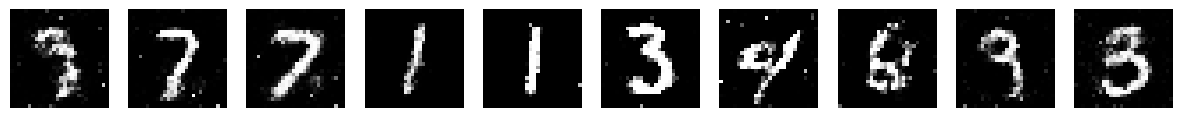

Epoch: 38/200 | Generator Loss: 1.4082943495911067 | Discriminator Loss: 0.471903764426327


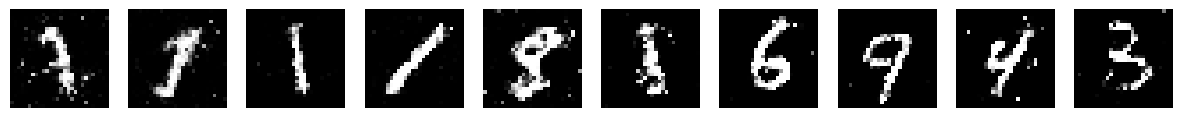

Epoch: 39/200 | Generator Loss: 1.3899696673919906 | Discriminator Loss: 0.47772621739901966


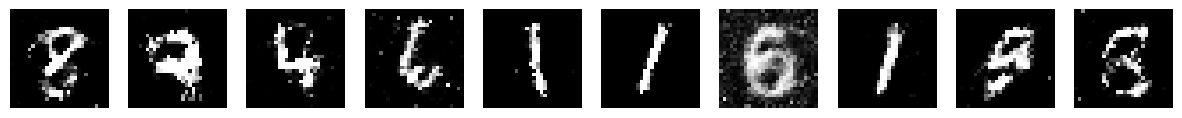

Epoch: 40/200 | Generator Loss: 1.387547134336378 | Discriminator Loss: 0.4790499549049304


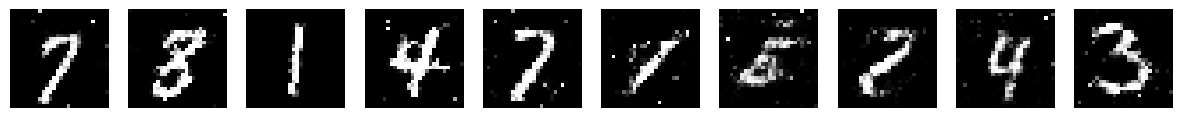

Epoch: 41/200 | Generator Loss: 1.3615179722751383 | Discriminator Loss: 0.48553215713897496


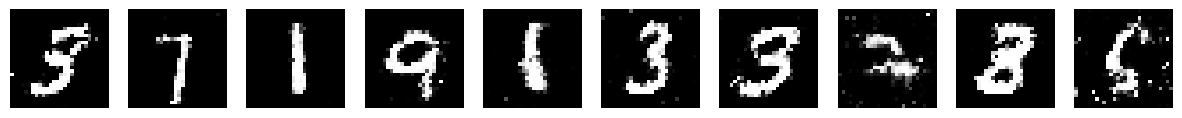

Epoch: 42/200 | Generator Loss: 1.3662120271593268 | Discriminator Loss: 0.48466432037384016


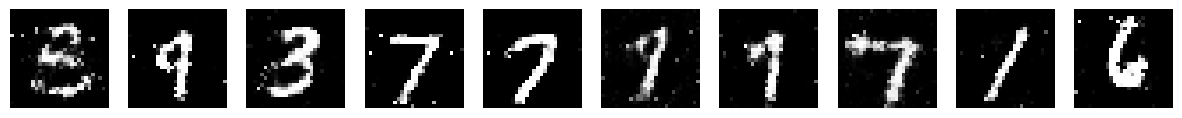

Epoch: 43/200 | Generator Loss: 1.3440089413860459 | Discriminator Loss: 0.4879327452004845


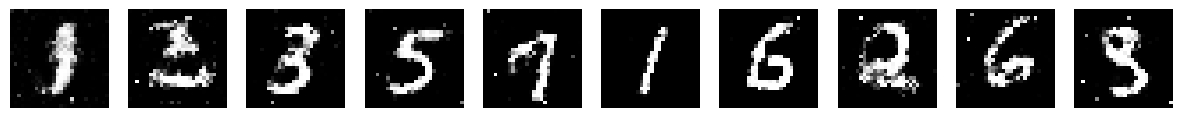

Epoch: 44/200 | Generator Loss: 1.3515949602574429 | Discriminator Loss: 0.48986281800880105


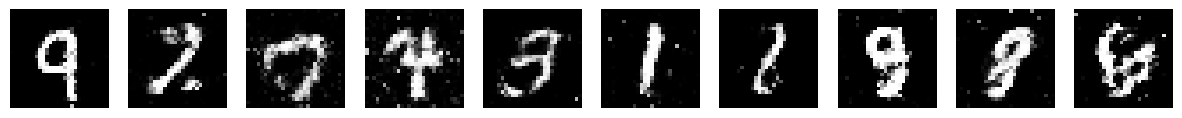

Epoch: 45/200 | Generator Loss: 1.3458479081135568 | Discriminator Loss: 0.4908174791696992


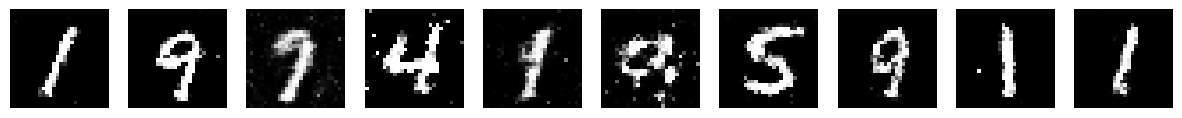

Epoch: 46/200 | Generator Loss: 1.330857444800802 | Discriminator Loss: 0.4986410575634889


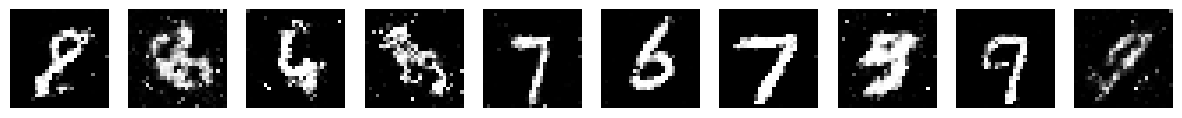

Epoch: 47/200 | Generator Loss: 1.3191855179983925 | Discriminator Loss: 0.4979251964387101


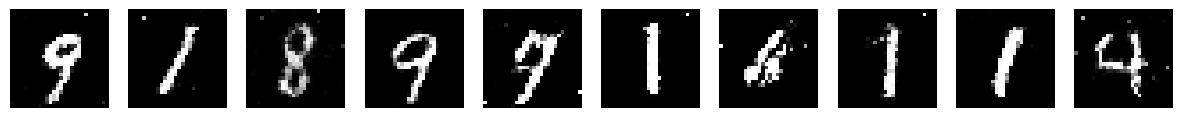

Epoch: 48/200 | Generator Loss: 1.3274479359706073 | Discriminator Loss: 0.496671297974678


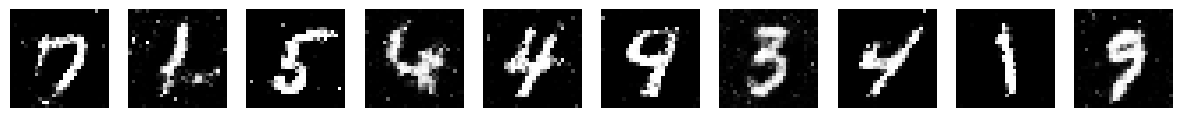

Epoch: 49/200 | Generator Loss: 1.3334383728153416 | Discriminator Loss: 0.4995250284417606


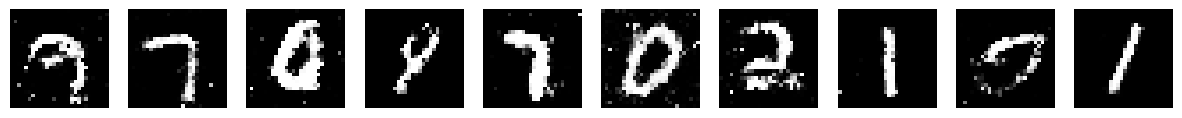

Epoch: 50/200 | Generator Loss: 1.3261479660392061 | Discriminator Loss: 0.4988659422661958


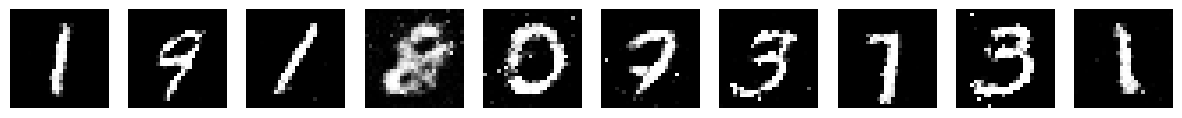

Epoch: 51/200 | Generator Loss: 1.3157142736255996 | Discriminator Loss: 0.502353722479806


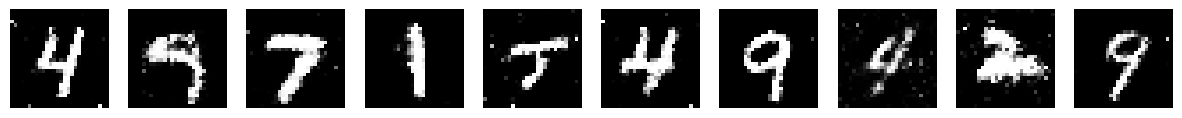

Epoch: 52/200 | Generator Loss: 1.3157950629557629 | Discriminator Loss: 0.5020720279420109


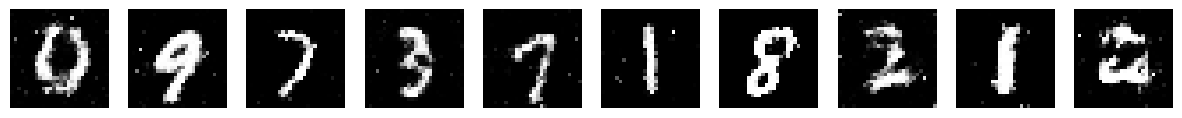

Epoch: 53/200 | Generator Loss: 1.3253818653793985 | Discriminator Loss: 0.5024063294249048


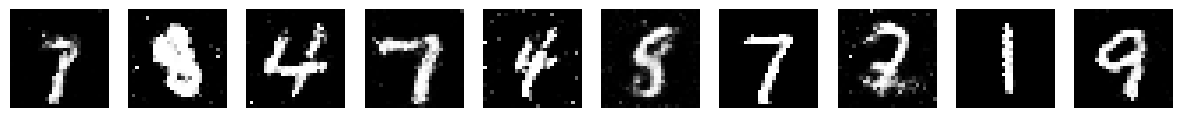

Epoch: 54/200 | Generator Loss: 1.3056211728276983 | Discriminator Loss: 0.5034577927863928


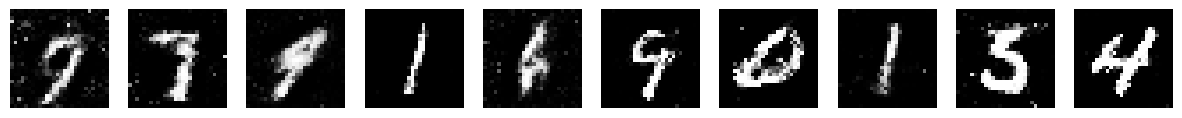

Epoch: 55/200 | Generator Loss: 1.3082130222178217 | Discriminator Loss: 0.5037949657770616


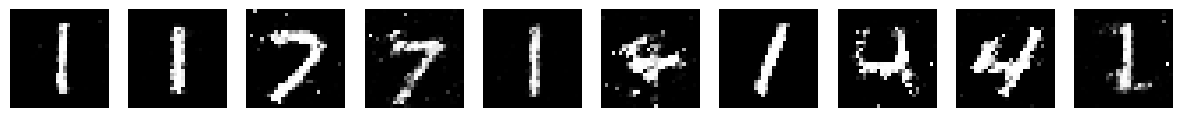

Epoch: 56/200 | Generator Loss: 1.2968362887530946 | Discriminator Loss: 0.506912857675349


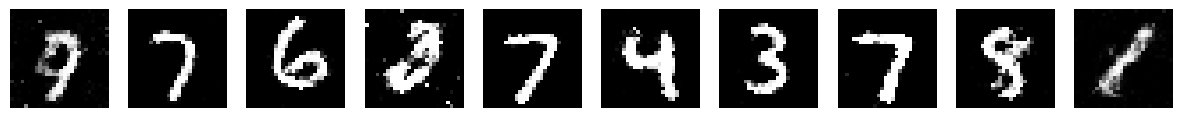

Epoch: 57/200 | Generator Loss: 1.2975119546786555 | Discriminator Loss: 0.5064920625452802


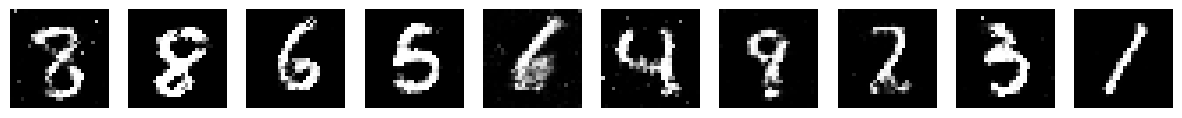

Epoch: 58/200 | Generator Loss: 1.2969284807441077 | Discriminator Loss: 0.5084859579483837


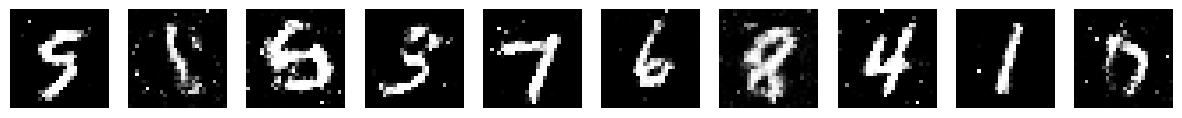

Epoch: 59/200 | Generator Loss: 1.287700995580474 | Discriminator Loss: 0.508774789538719


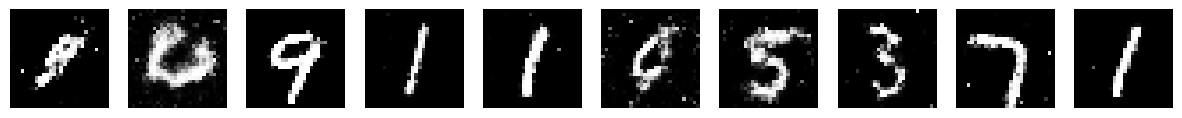

Epoch: 60/200 | Generator Loss: 1.2972309942692837 | Discriminator Loss: 0.5088376141052002


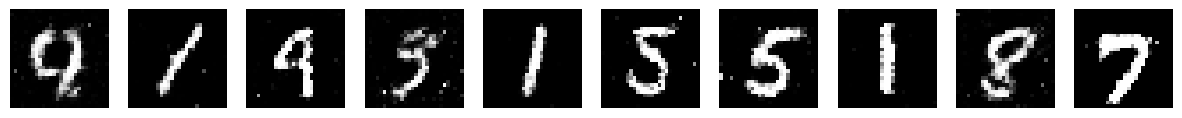

Epoch: 61/200 | Generator Loss: 1.2879893566245464 | Discriminator Loss: 0.5107325884197821


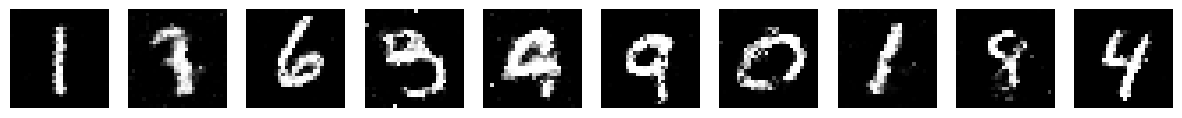

Epoch: 62/200 | Generator Loss: 1.2804987428030734 | Discriminator Loss: 0.5139331461142883


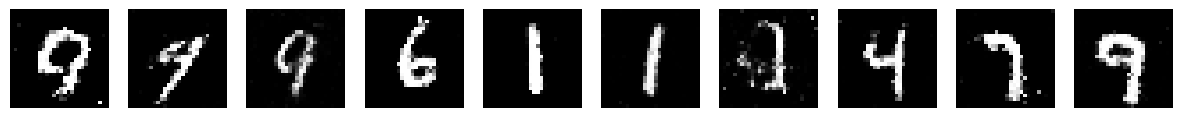

Epoch: 63/200 | Generator Loss: 1.2703585097276326 | Discriminator Loss: 0.5156329956008936


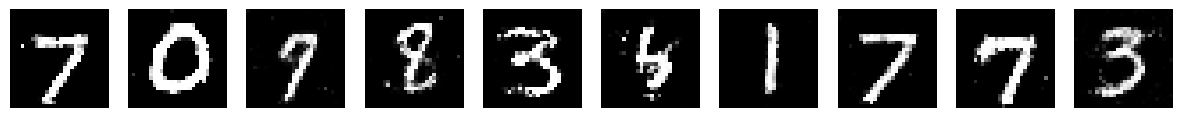

Epoch: 64/200 | Generator Loss: 1.2874239683151245 | Discriminator Loss: 0.5097580805643281


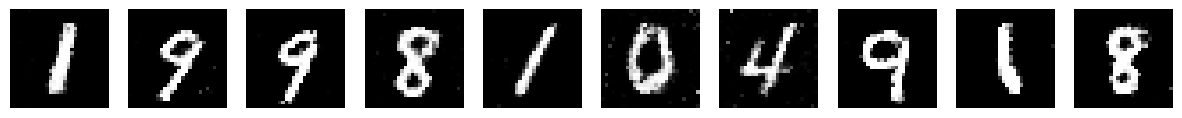

Epoch: 65/200 | Generator Loss: 1.2631313854189061 | Discriminator Loss: 0.5187083867185914


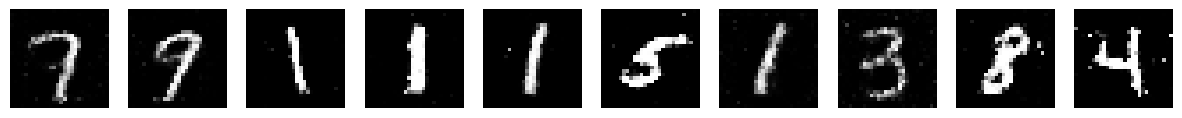

Epoch: 66/200 | Generator Loss: 1.2693173727755354 | Discriminator Loss: 0.5140999987054227


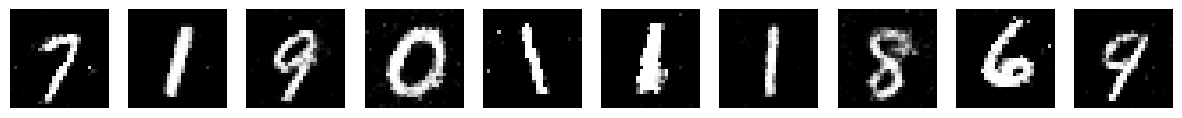

Epoch: 67/200 | Generator Loss: 1.2754521156424907 | Discriminator Loss: 0.5135932255909641


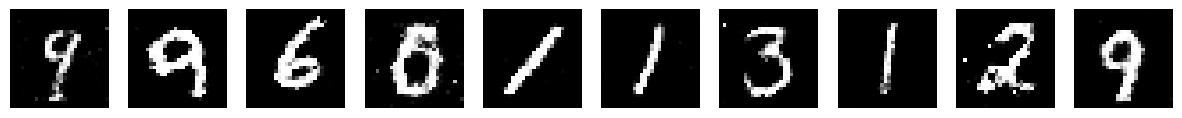

Epoch: 68/200 | Generator Loss: 1.2728104133849967 | Discriminator Loss: 0.5150403333371127


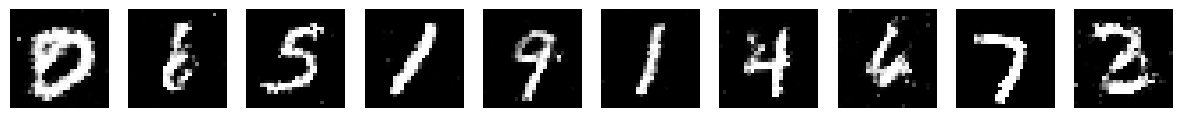

Epoch: 69/200 | Generator Loss: 1.2981386027102277 | Discriminator Loss: 0.5088671799788851


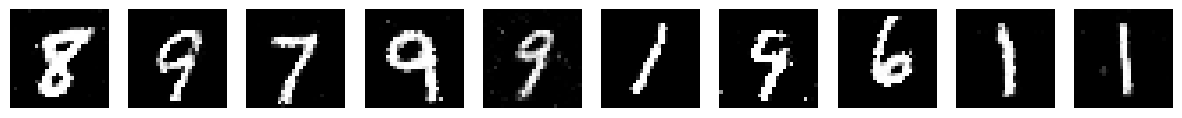

Epoch: 70/200 | Generator Loss: 1.2820465798571166 | Discriminator Loss: 0.5136819675024639


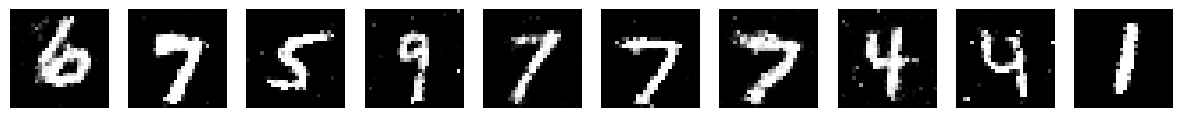

Epoch: 71/200 | Generator Loss: 1.2745241806197014 | Discriminator Loss: 0.515791285076121


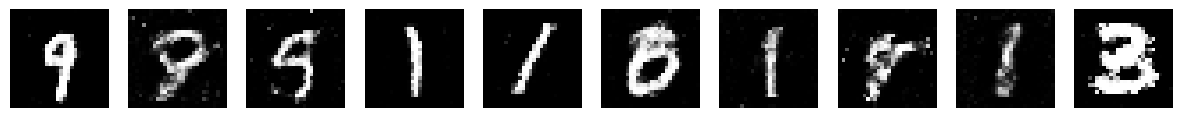

Epoch: 72/200 | Generator Loss: 1.2751382716429005 | Discriminator Loss: 0.513745492074027


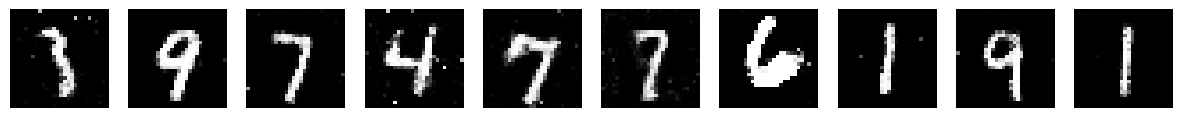

Epoch: 73/200 | Generator Loss: 1.2565613143733825 | Discriminator Loss: 0.5182435879829341


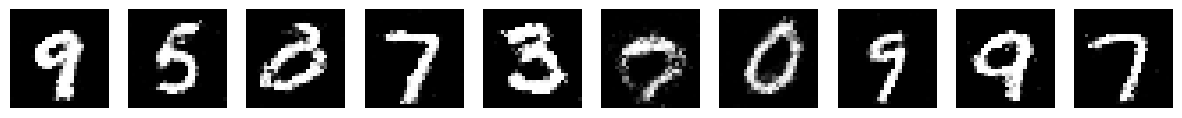

Epoch: 74/200 | Generator Loss: 1.2668376947516826 | Discriminator Loss: 0.5182260540502666


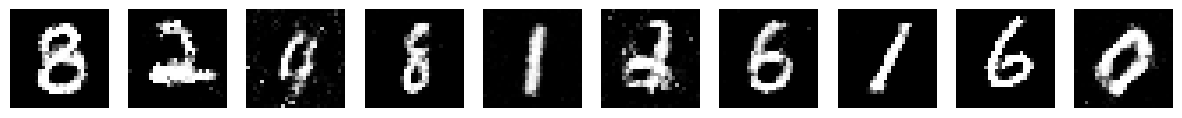

Epoch: 75/200 | Generator Loss: 1.2720488963096634 | Discriminator Loss: 0.5146283939449009


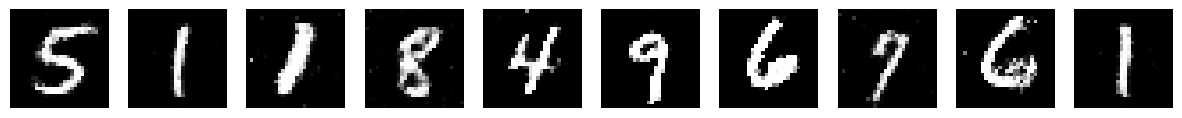

Epoch: 76/200 | Generator Loss: 1.2736313856486827 | Discriminator Loss: 0.5158948877981222


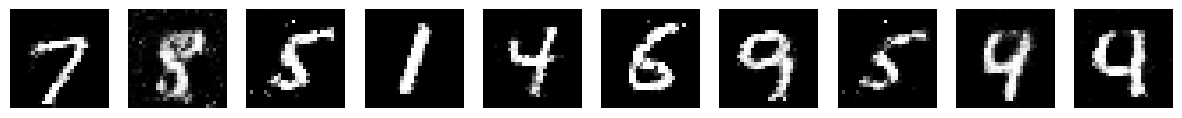

Epoch: 77/200 | Generator Loss: 1.263604591650241 | Discriminator Loss: 0.5173286374316795


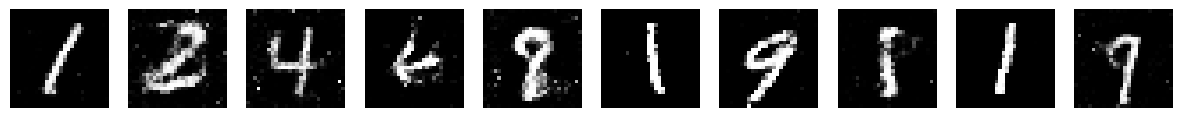

Epoch: 78/200 | Generator Loss: 1.2744014575791511 | Discriminator Loss: 0.5141880127793944


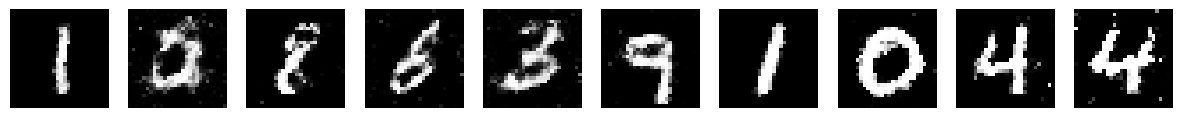

Epoch: 79/200 | Generator Loss: 1.2736875210235368 | Discriminator Loss: 0.5138817163291516


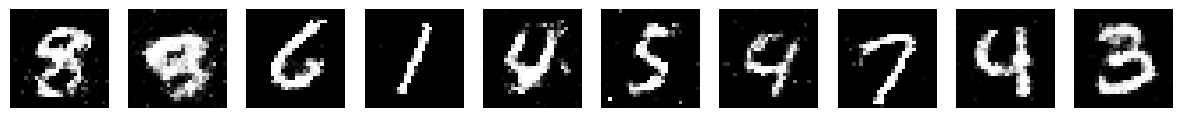

Epoch: 80/200 | Generator Loss: 1.2639589976908556 | Discriminator Loss: 0.5164777970136102


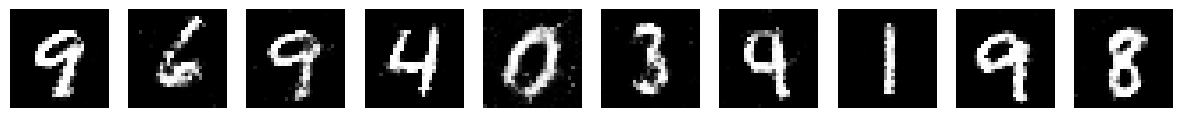

Epoch: 81/200 | Generator Loss: 1.2628042028148545 | Discriminator Loss: 0.5195886063169061


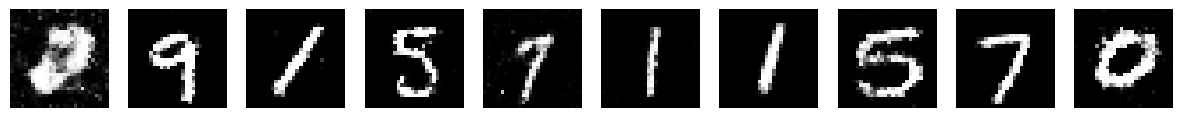

Epoch: 82/200 | Generator Loss: 1.2568633955424782 | Discriminator Loss: 0.519765576319908


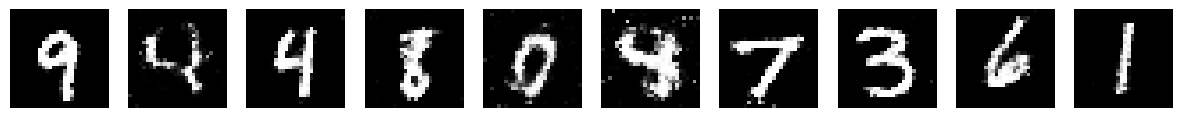

Epoch: 83/200 | Generator Loss: 1.2796706075607331 | Discriminator Loss: 0.5141327259764235


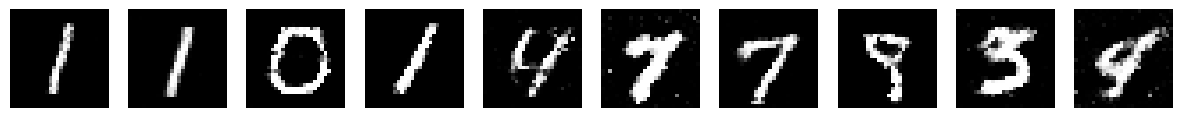

Epoch: 84/200 | Generator Loss: 1.2597384333356356 | Discriminator Loss: 0.5178990531831916


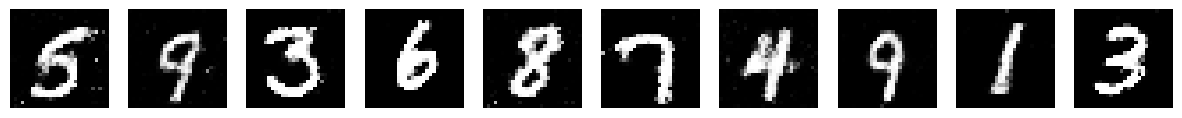

Epoch: 85/200 | Generator Loss: 1.2520576016480989 | Discriminator Loss: 0.5206864822520885


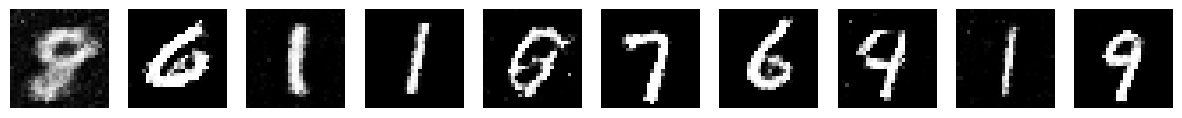

Epoch: 86/200 | Generator Loss: 1.2750370416051544 | Discriminator Loss: 0.518219082721515


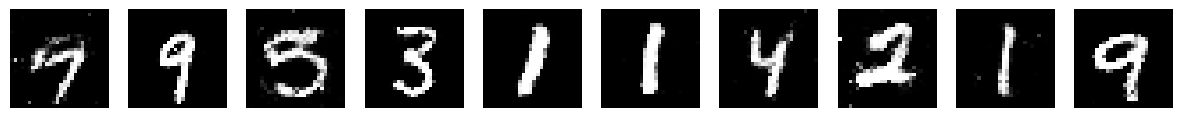

Epoch: 87/200 | Generator Loss: 1.2601962697023013 | Discriminator Loss: 0.5193379978254151


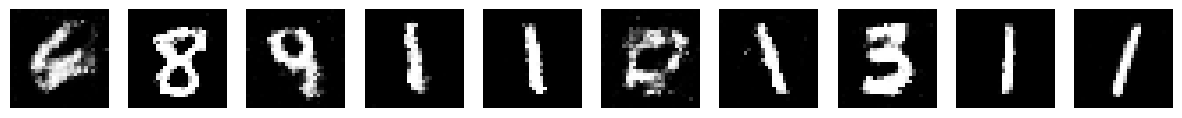

Epoch: 88/200 | Generator Loss: 1.2661558409997904 | Discriminator Loss: 0.5202103125006914


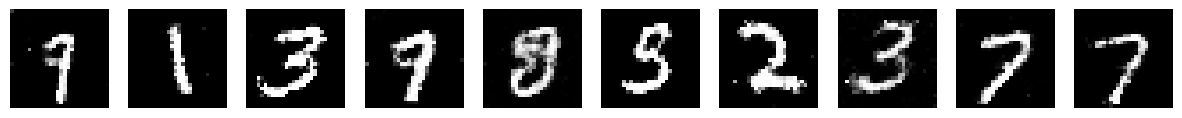

Epoch: 89/200 | Generator Loss: 1.26293301099399 | Discriminator Loss: 0.5180718643324715


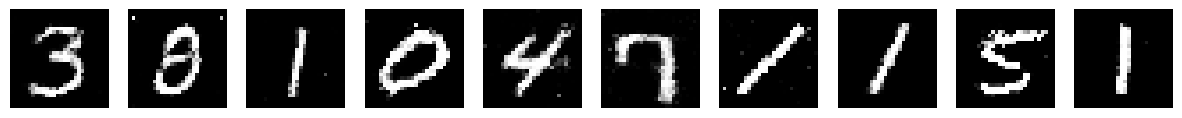

Epoch: 90/200 | Generator Loss: 1.2687721036390456 | Discriminator Loss: 0.5171378709868327


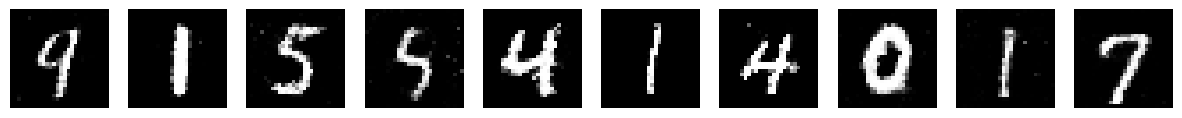

Epoch: 91/200 | Generator Loss: 1.2700445710468902 | Discriminator Loss: 0.5155291650086832


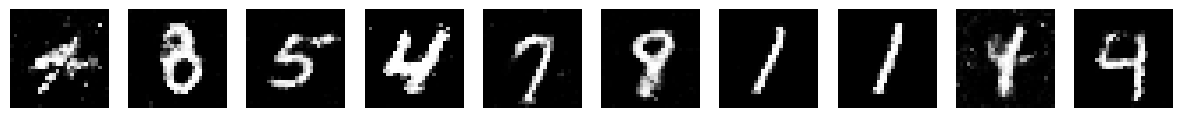

Epoch: 92/200 | Generator Loss: 1.2643047278878023 | Discriminator Loss: 0.51913877546406


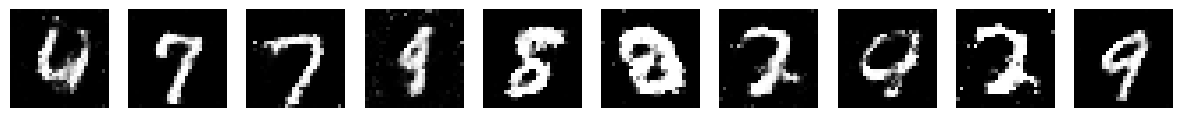

Epoch: 93/200 | Generator Loss: 1.2662325012150095 | Discriminator Loss: 0.5182775271726824


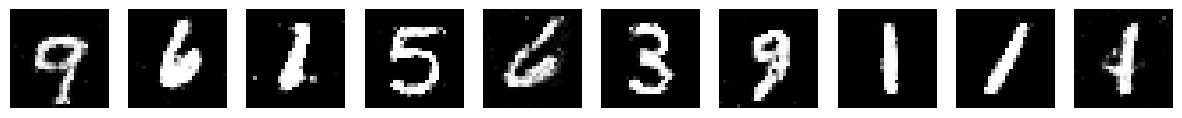

Epoch: 94/200 | Generator Loss: 1.2620577977410257 | Discriminator Loss: 0.5195438758905


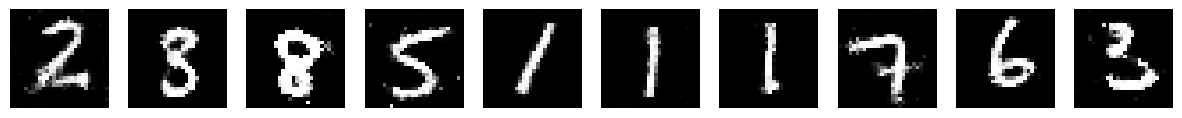

Epoch: 95/200 | Generator Loss: 1.2645901568662892 | Discriminator Loss: 0.5185046342136


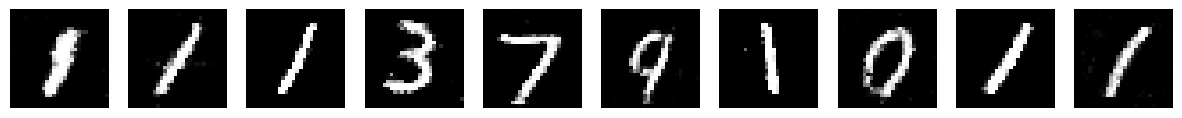

Epoch: 96/200 | Generator Loss: 1.2630758727791467 | Discriminator Loss: 0.5202355736227178


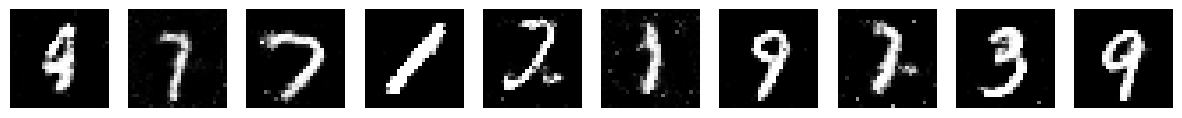

Epoch: 97/200 | Generator Loss: 1.266171617548603 | Discriminator Loss: 0.5183148017443066


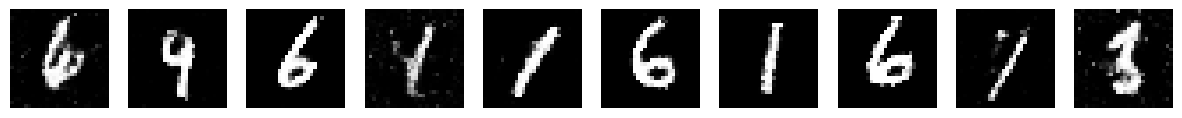

Epoch: 98/200 | Generator Loss: 1.2611411675207143 | Discriminator Loss: 0.5174496993581369


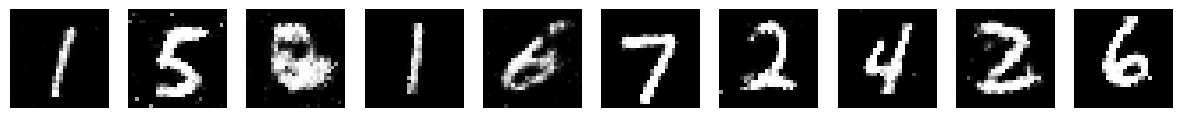

Epoch: 99/200 | Generator Loss: 1.2643744809541113 | Discriminator Loss: 0.5179942153664286


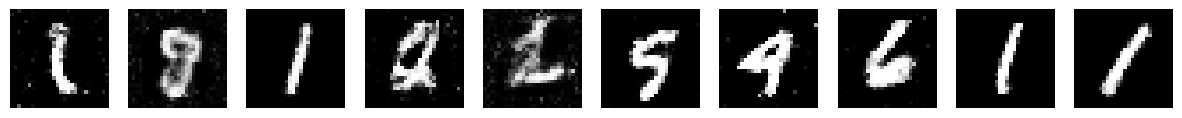

Epoch: 100/200 | Generator Loss: 1.2763282668107607 | Discriminator Loss: 0.5175167292292947


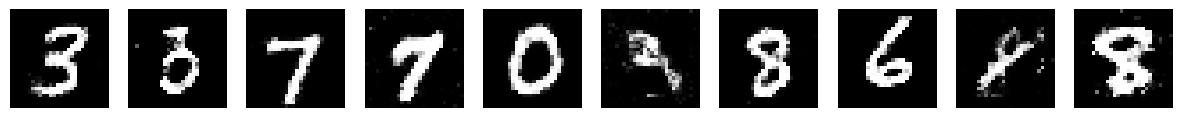

Epoch: 101/200 | Generator Loss: 1.2742098409738114 | Discriminator Loss: 0.5166428751274467


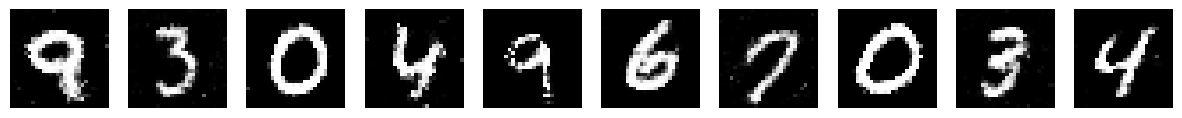

Epoch: 102/200 | Generator Loss: 1.2743540083421574 | Discriminator Loss: 0.5190254649373768


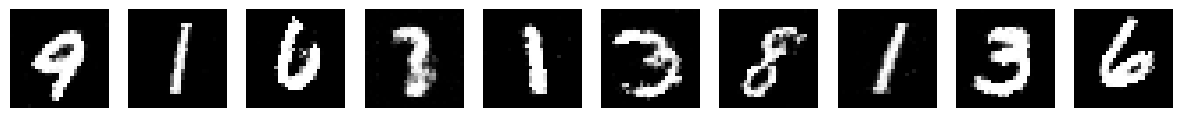

Epoch: 103/200 | Generator Loss: 1.262008616537936 | Discriminator Loss: 0.5197641429489356


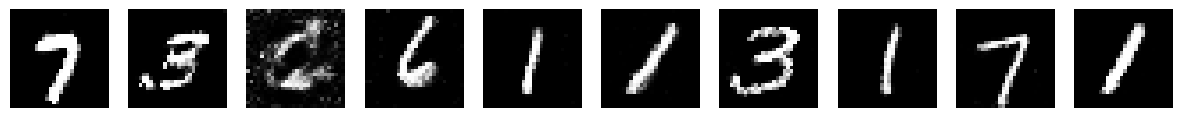

Epoch: 104/200 | Generator Loss: 1.2590140071250737 | Discriminator Loss: 0.5202827209602795


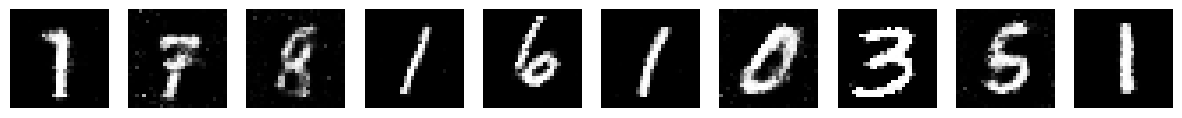

Epoch: 105/200 | Generator Loss: 1.2638961371582453 | Discriminator Loss: 0.5195084971659727


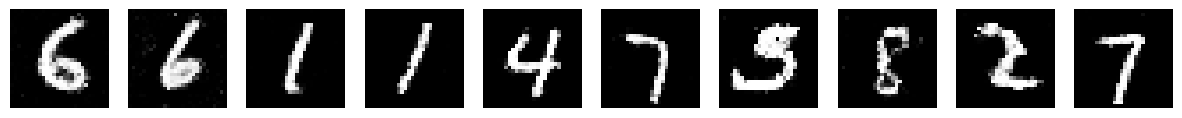

Epoch: 106/200 | Generator Loss: 1.258835828380544 | Discriminator Loss: 0.5205131894362761


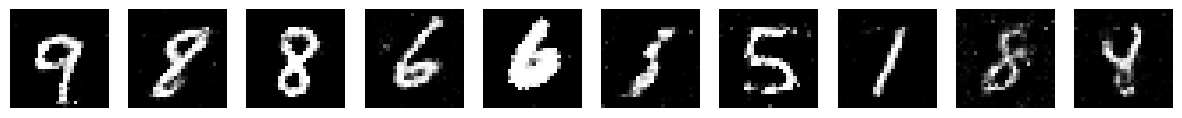

Epoch: 107/200 | Generator Loss: 1.2654831910184197 | Discriminator Loss: 0.52026857070323


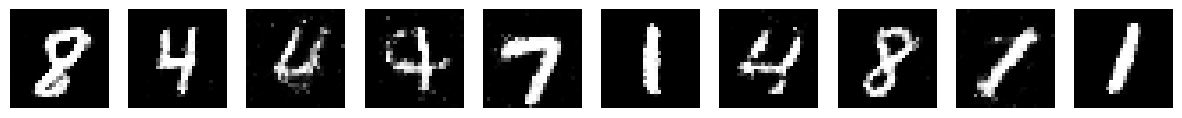

Epoch: 108/200 | Generator Loss: 1.2697686157755252 | Discriminator Loss: 0.5193746101373294


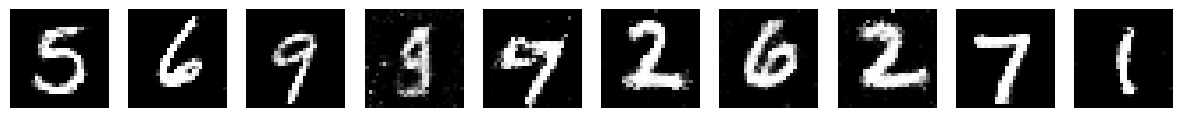

Epoch: 109/200 | Generator Loss: 1.2621123990270375 | Discriminator Loss: 0.5184038472709371


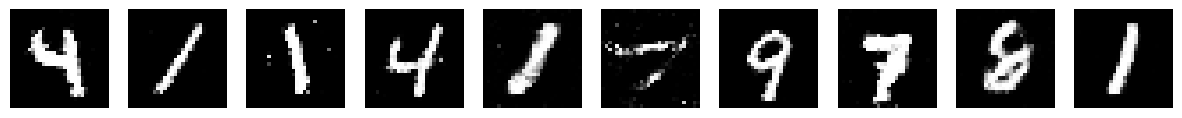

Epoch: 110/200 | Generator Loss: 1.2699612685358093 | Discriminator Loss: 0.5174891226200152


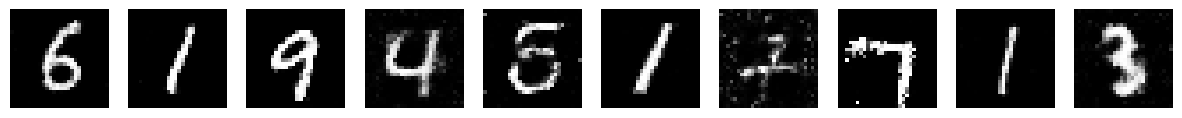

Epoch: 111/200 | Generator Loss: 1.2658111634793312 | Discriminator Loss: 0.5172658065107586


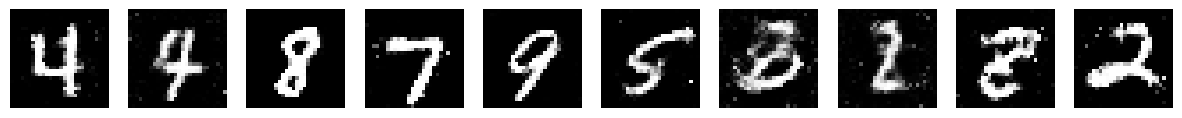

Epoch: 112/200 | Generator Loss: 1.2706476724478228 | Discriminator Loss: 0.5165180579812796


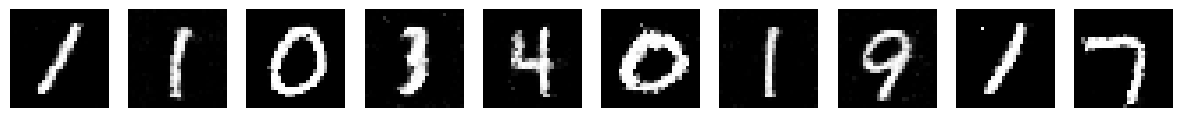

Epoch: 113/200 | Generator Loss: 1.277277395160976 | Discriminator Loss: 0.5139774878396154


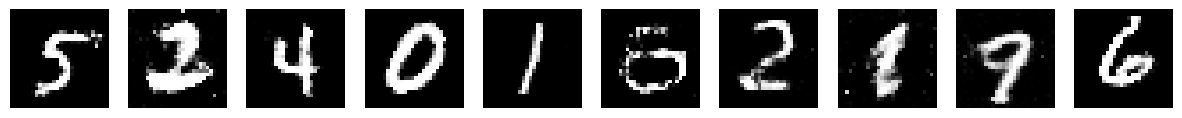

Epoch: 114/200 | Generator Loss: 1.2807520137412716 | Discriminator Loss: 0.5144355583038411


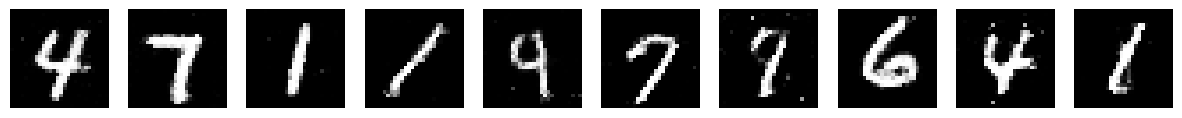

Epoch: 115/200 | Generator Loss: 1.2796459637725277 | Discriminator Loss: 0.5153152028889035


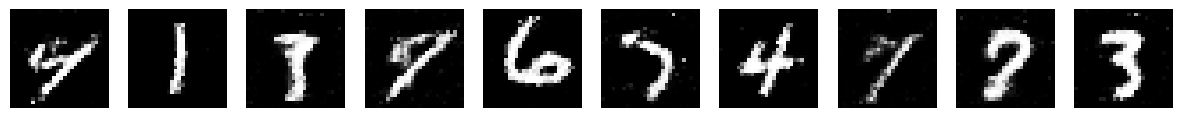

Epoch: 116/200 | Generator Loss: 1.3003931510677216 | Discriminator Loss: 0.5105599931943645


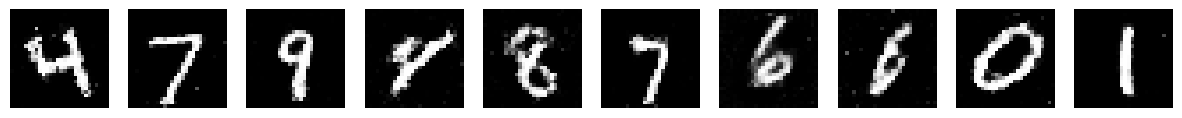

Epoch: 117/200 | Generator Loss: 1.289108192488583 | Discriminator Loss: 0.5134649782546802


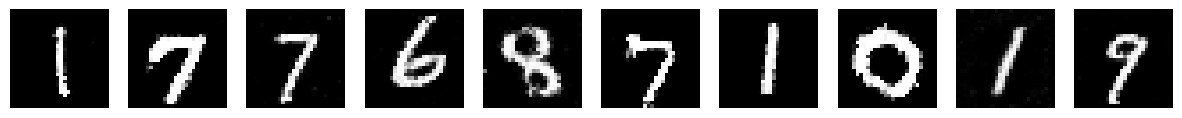

Epoch: 118/200 | Generator Loss: 1.3011942288514649 | Discriminator Loss: 0.5112871823153262


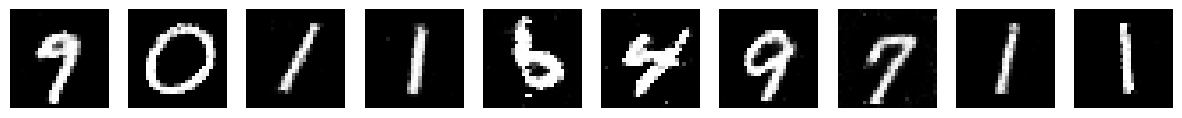

Epoch: 119/200 | Generator Loss: 1.2883166400100123 | Discriminator Loss: 0.5147361897710544


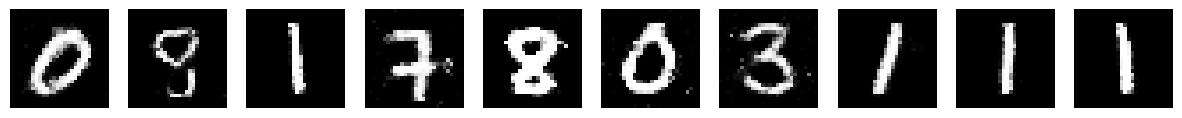

Epoch: 120/200 | Generator Loss: 1.2790402219747938 | Discriminator Loss: 0.5138133402699346


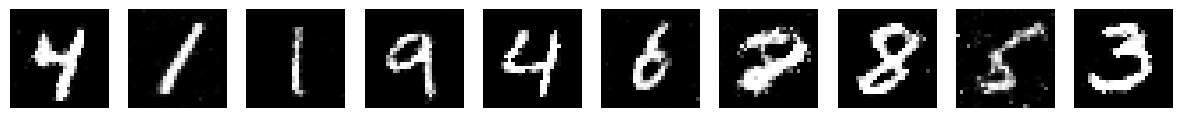

Epoch: 121/200 | Generator Loss: 1.2810226891086554 | Discriminator Loss: 0.5126914535758338


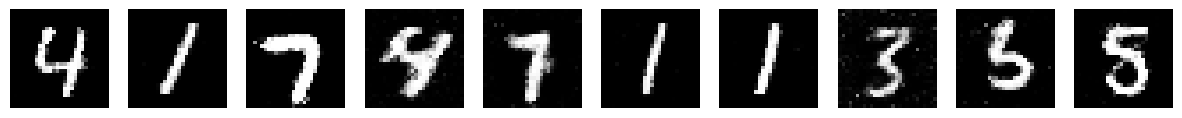

Epoch: 122/200 | Generator Loss: 1.287452600658067 | Discriminator Loss: 0.5125357288160304


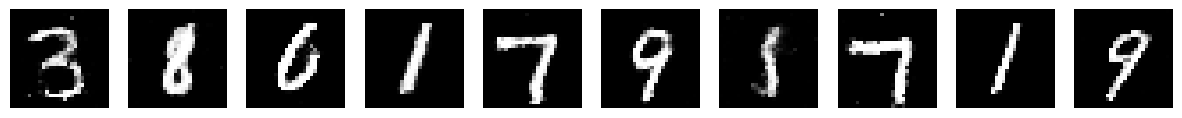

Epoch: 123/200 | Generator Loss: 1.2824615283307237 | Discriminator Loss: 0.5140681687448578


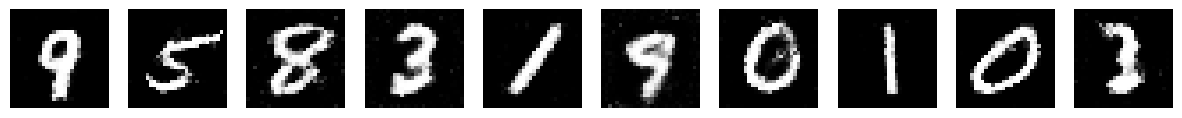

Epoch: 124/200 | Generator Loss: 1.2914254889051036 | Discriminator Loss: 0.5132043365476482


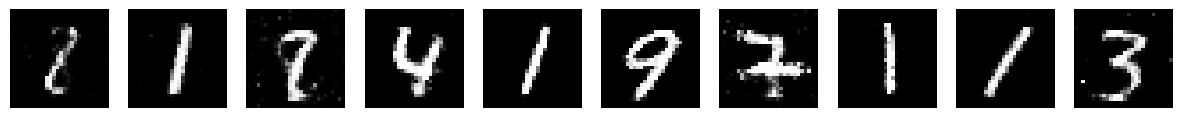

Epoch: 125/200 | Generator Loss: 1.28674052773254 | Discriminator Loss: 0.5135629197427714


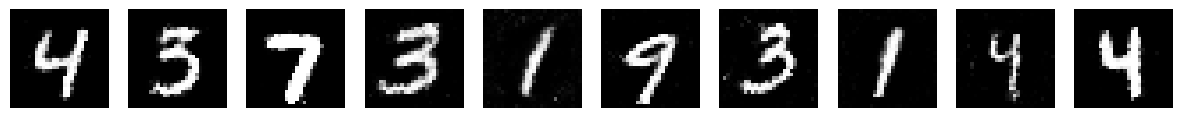

Epoch: 126/200 | Generator Loss: 1.301590413427048 | Discriminator Loss: 0.5111708960680565


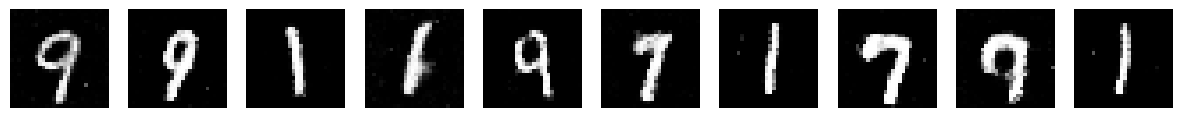

Epoch: 127/200 | Generator Loss: 1.2952600476075846 | Discriminator Loss: 0.5116578780257626


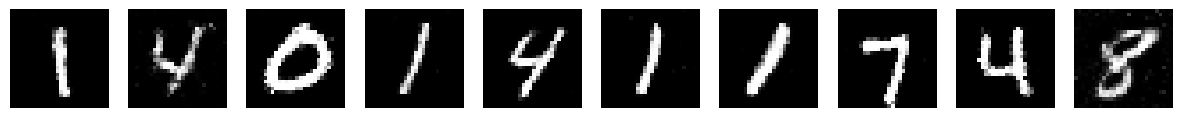

Epoch: 128/200 | Generator Loss: 1.290580224634996 | Discriminator Loss: 0.5104342650757161


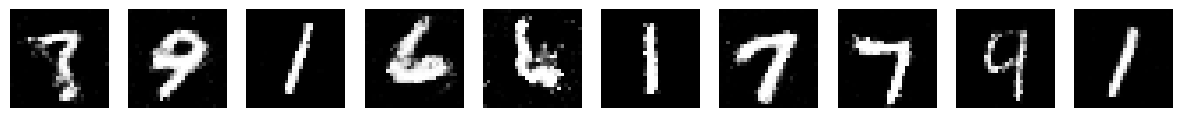

Epoch: 129/200 | Generator Loss: 1.2945460787714163 | Discriminator Loss: 0.5107504162452877


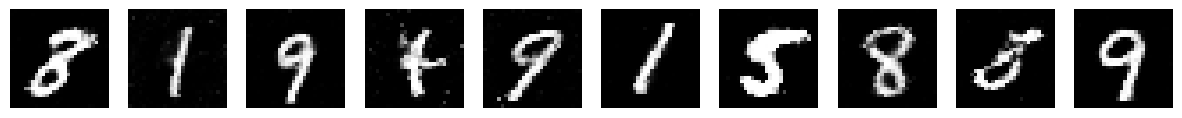

Epoch: 130/200 | Generator Loss: 1.2941327537300744 | Discriminator Loss: 0.5109935724404829


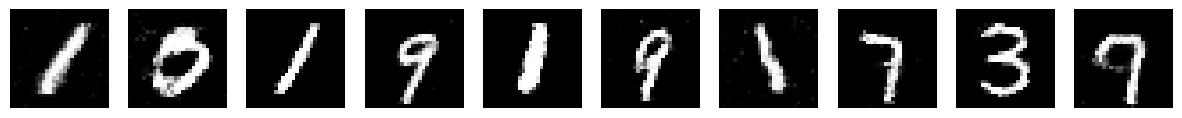

Epoch: 131/200 | Generator Loss: 1.2928819902924333 | Discriminator Loss: 0.5124284236161694


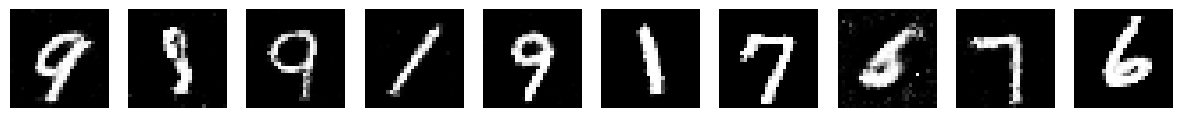

Epoch: 132/200 | Generator Loss: 1.289469832550488 | Discriminator Loss: 0.5138186675144919


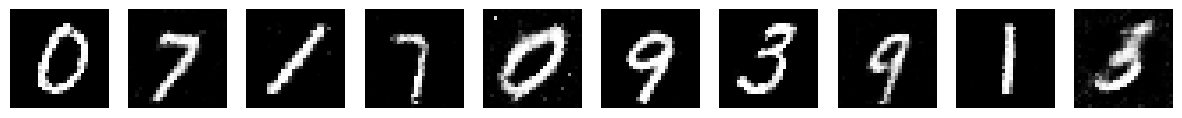

Epoch: 133/200 | Generator Loss: 1.2974732153451265 | Discriminator Loss: 0.5110882961673777


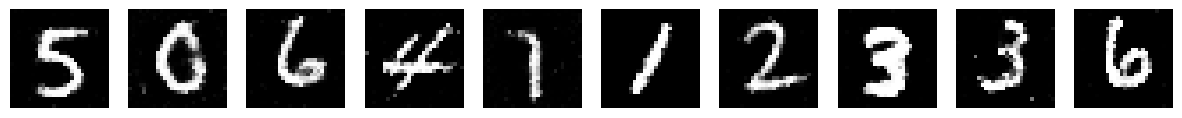

Epoch: 134/200 | Generator Loss: 1.288842091174014 | Discriminator Loss: 0.5127706779345774


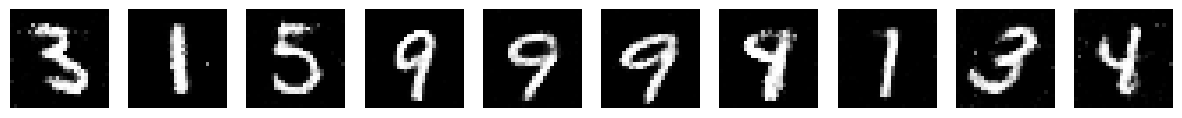

Epoch: 135/200 | Generator Loss: 1.3116318345832418 | Discriminator Loss: 0.5079113960520291


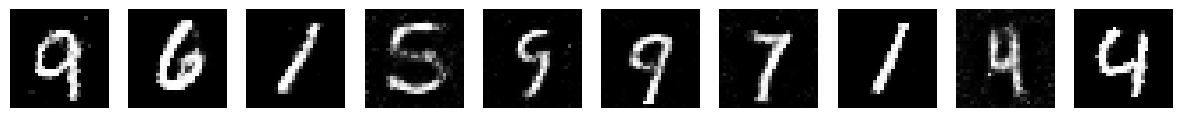

Epoch: 136/200 | Generator Loss: 1.3067202687517667 | Discriminator Loss: 0.5106231126068498


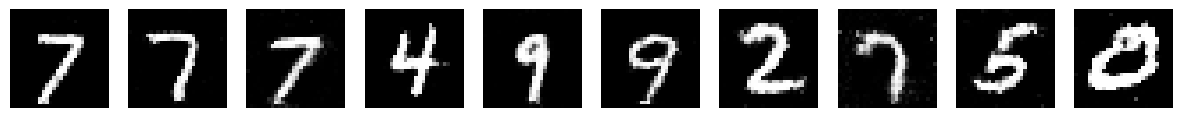

Epoch: 137/200 | Generator Loss: 1.3030196481676244 | Discriminator Loss: 0.5113866275815822


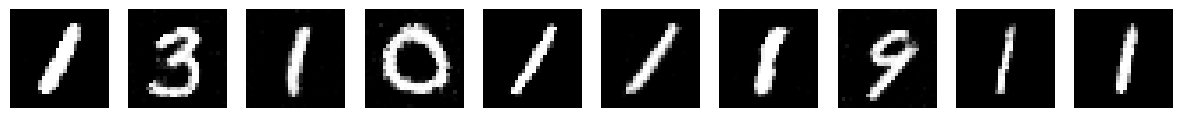

Epoch: 138/200 | Generator Loss: 1.3004935463862632 | Discriminator Loss: 0.5094110003666583


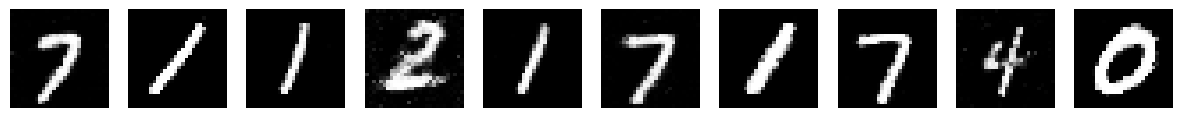

Epoch: 139/200 | Generator Loss: 1.3034703317227394 | Discriminator Loss: 0.5092567101851709


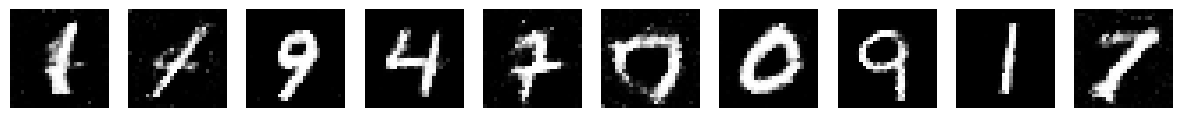

Epoch: 140/200 | Generator Loss: 1.3051500935544338 | Discriminator Loss: 0.5099467767962514


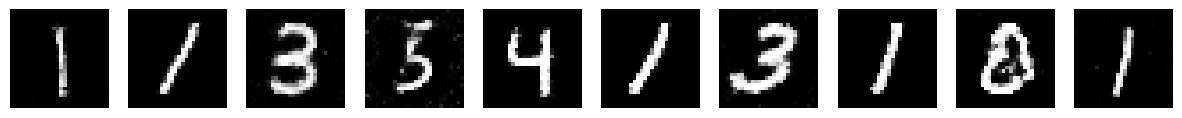

Epoch: 141/200 | Generator Loss: 1.2920279345278547 | Discriminator Loss: 0.5110571939807965


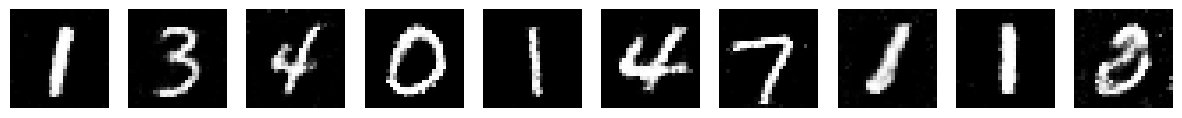

Epoch: 142/200 | Generator Loss: 1.312866520525804 | Discriminator Loss: 0.5062954545275234


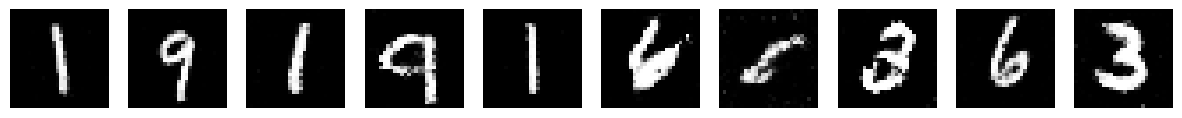

Epoch: 143/200 | Generator Loss: 1.309882079614505 | Discriminator Loss: 0.5100654912020351


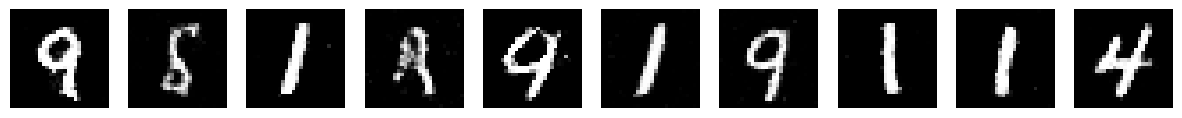

Epoch: 144/200 | Generator Loss: 1.2979627629078783 | Discriminator Loss: 0.509898235548788


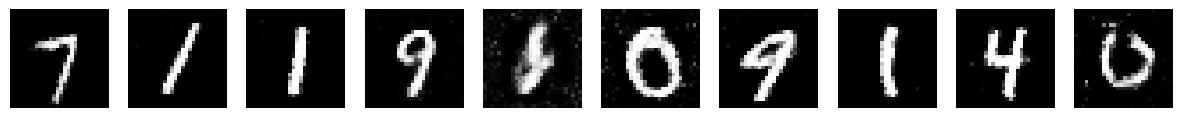

Epoch: 145/200 | Generator Loss: 1.3110701056685783 | Discriminator Loss: 0.5074596261418959


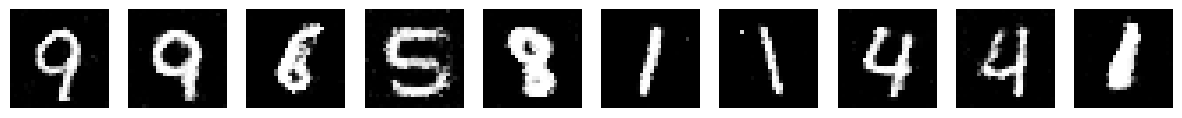

Epoch: 146/200 | Generator Loss: 1.3150926485244654 | Discriminator Loss: 0.50719648243776


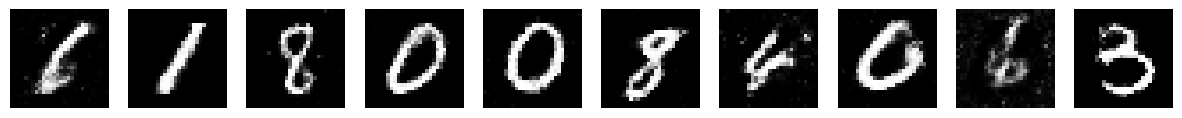

Epoch: 147/200 | Generator Loss: 1.3187866538826591 | Discriminator Loss: 0.5051915945528921


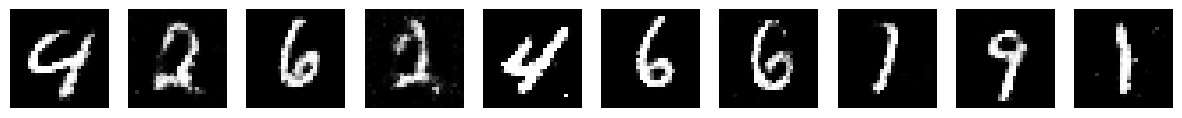

Epoch: 148/200 | Generator Loss: 1.320383431814881 | Discriminator Loss: 0.5055101619981753


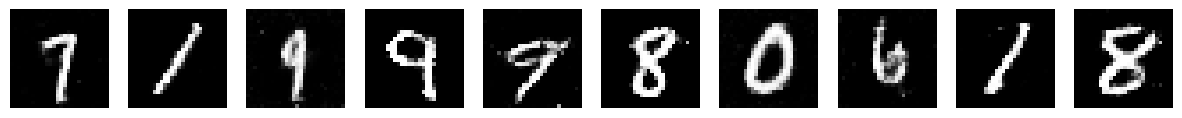

Epoch: 149/200 | Generator Loss: 1.3133934499866673 | Discriminator Loss: 0.5093551914193737


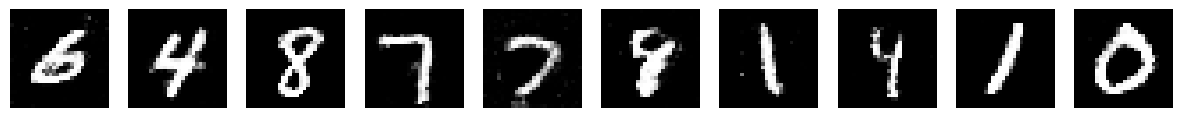

Epoch: 150/200 | Generator Loss: 1.3081450879192555 | Discriminator Loss: 0.5072527387376025


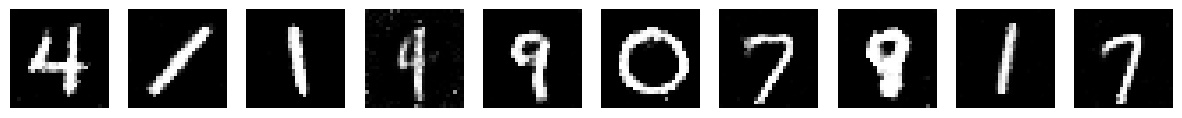

Epoch: 151/200 | Generator Loss: 1.3217840555634326 | Discriminator Loss: 0.5038607900203672


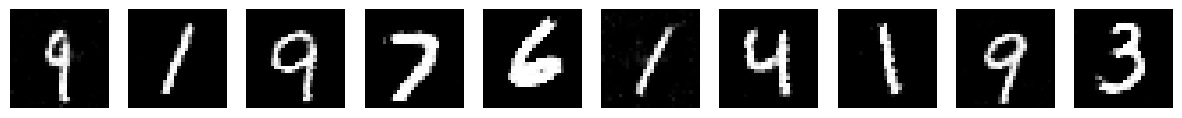

Epoch: 152/200 | Generator Loss: 1.3124586370453906 | Discriminator Loss: 0.5071010559733743


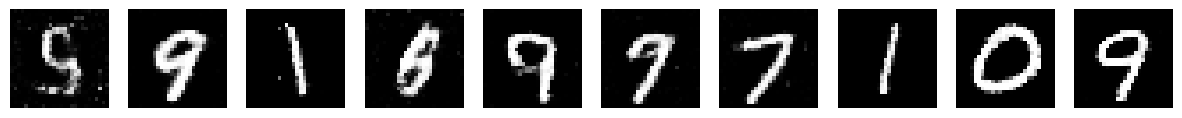

Epoch: 153/200 | Generator Loss: 1.3247756505571704 | Discriminator Loss: 0.5037988916770227


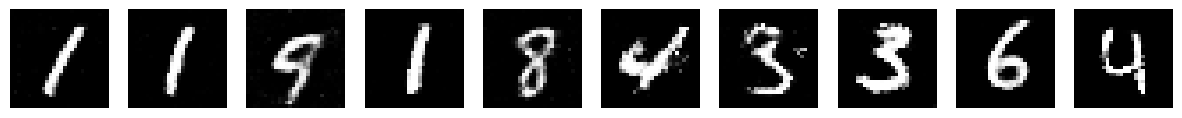

Epoch: 154/200 | Generator Loss: 1.333652898701015 | Discriminator Loss: 0.5027946822805953


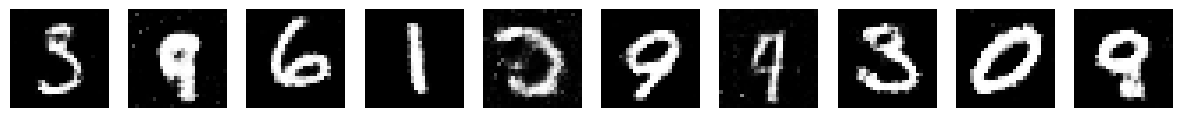

Epoch: 155/200 | Generator Loss: 1.3284247762867127 | Discriminator Loss: 0.5025943209494609


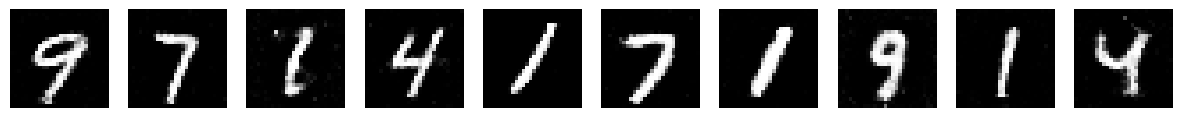

Epoch: 156/200 | Generator Loss: 1.336474821003261 | Discriminator Loss: 0.5007757216628427


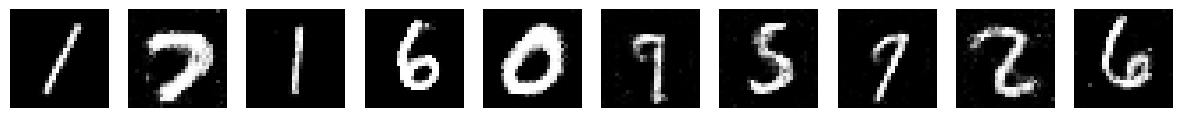

Epoch: 157/200 | Generator Loss: 1.341705312352699 | Discriminator Loss: 0.4989192014309897


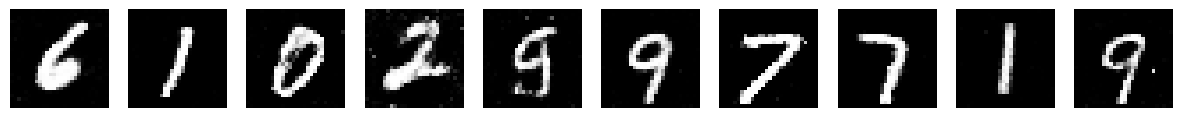

Epoch: 158/200 | Generator Loss: 1.3510166447299885 | Discriminator Loss: 0.5021118538847356


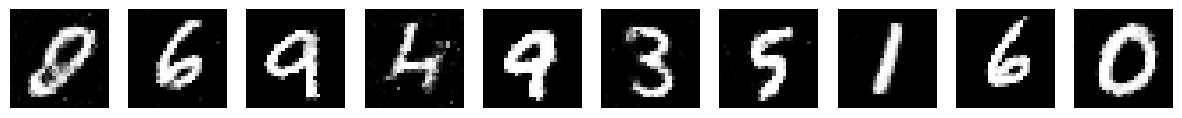

Epoch: 159/200 | Generator Loss: 1.3289240057280323 | Discriminator Loss: 0.5049999290819107


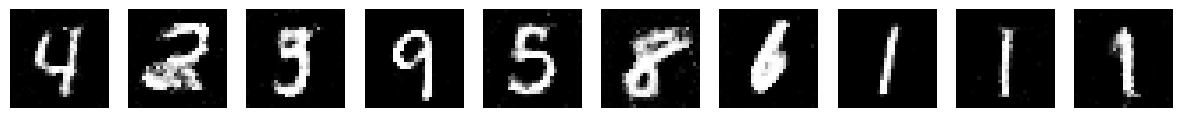

Epoch: 160/200 | Generator Loss: 1.3283274308450694 | Discriminator Loss: 0.5044665205071984


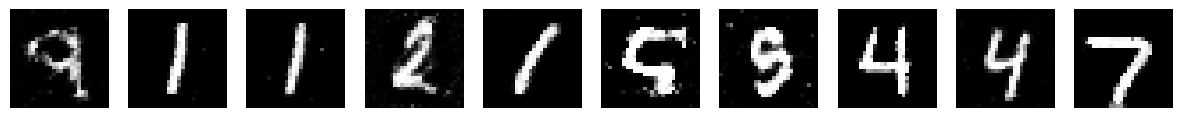

Epoch: 161/200 | Generator Loss: 1.3386565873871987 | Discriminator Loss: 0.5017426658286723


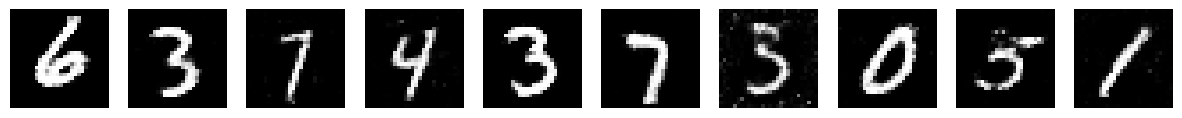

Epoch: 162/200 | Generator Loss: 1.3426103297072942 | Discriminator Loss: 0.5015782269079294


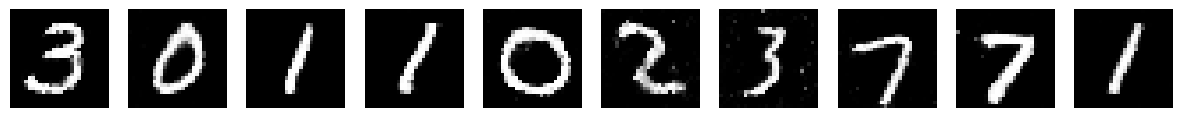

Epoch: 163/200 | Generator Loss: 1.332581918122672 | Discriminator Loss: 0.5012775745346094


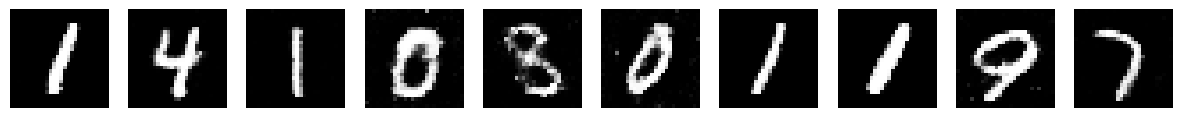

Epoch: 164/200 | Generator Loss: 1.341824658389793 | Discriminator Loss: 0.5005370564679347


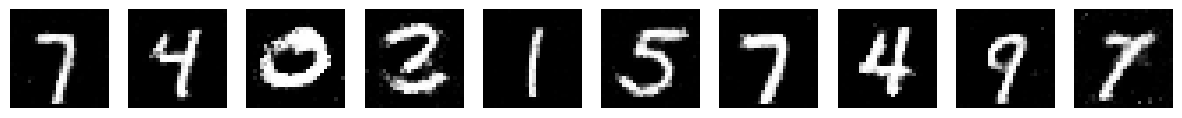

Epoch: 165/200 | Generator Loss: 1.3442895352713335 | Discriminator Loss: 0.5005277938553011


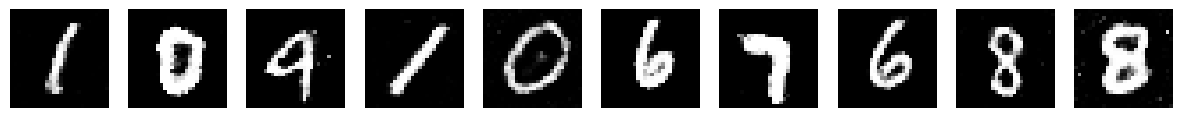

Epoch: 166/200 | Generator Loss: 1.3405397853363297 | Discriminator Loss: 0.501382155077798


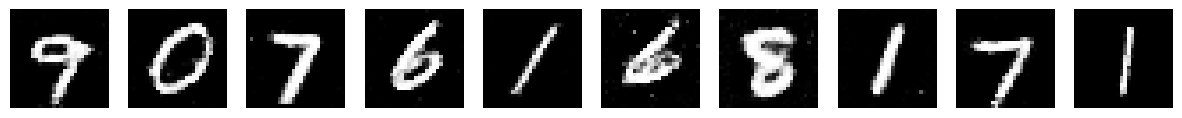

Epoch: 167/200 | Generator Loss: 1.343076066167624 | Discriminator Loss: 0.4984348929767161


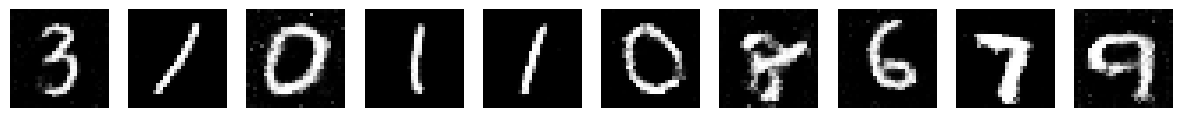

Epoch: 168/200 | Generator Loss: 1.330746349495357 | Discriminator Loss: 0.5004684693777739


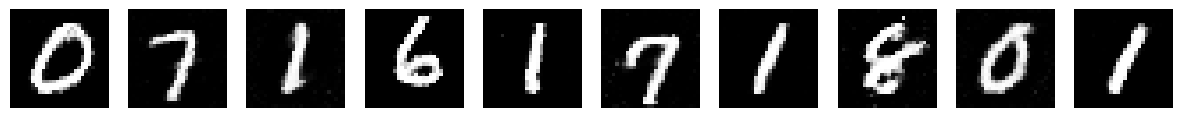

Epoch: 169/200 | Generator Loss: 1.3577039933153816 | Discriminator Loss: 0.49888182963643757


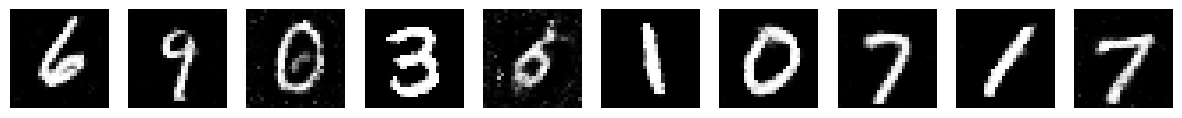

Epoch: 170/200 | Generator Loss: 1.3392279842006627 | Discriminator Loss: 0.5023385423587076


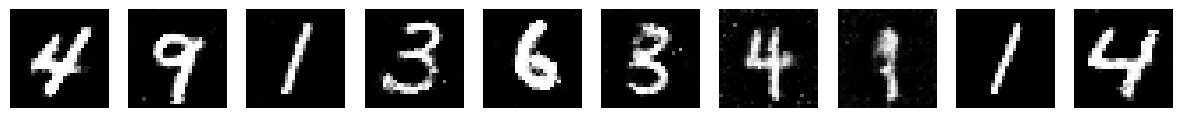

Epoch: 171/200 | Generator Loss: 1.3584198105309817 | Discriminator Loss: 0.49784008818648773


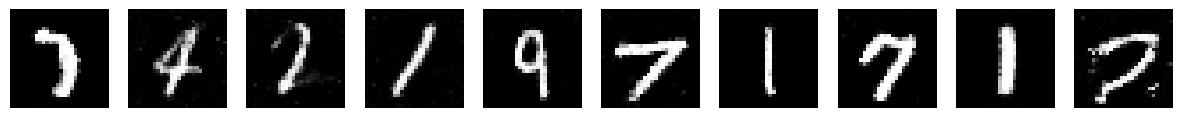

Epoch: 172/200 | Generator Loss: 1.3481659157189734 | Discriminator Loss: 0.49818705896070514


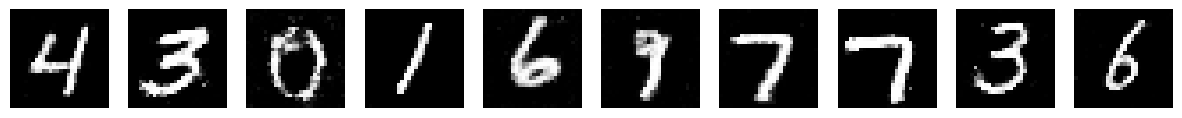

Epoch: 173/200 | Generator Loss: 1.355626346714207 | Discriminator Loss: 0.49545261549797137


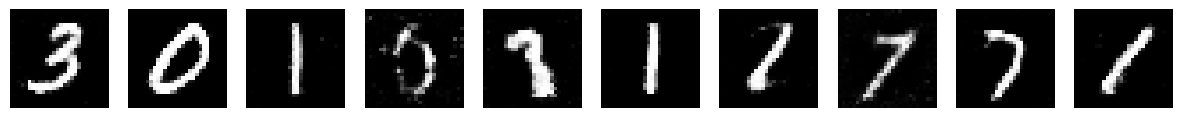

Epoch: 174/200 | Generator Loss: 1.3458171391537956 | Discriminator Loss: 0.49699754196443535


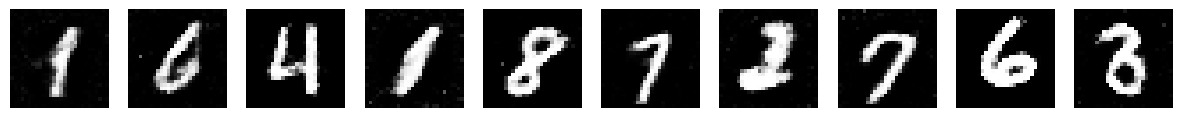

Epoch: 175/200 | Generator Loss: 1.3529682459353385 | Discriminator Loss: 0.4976237646933558


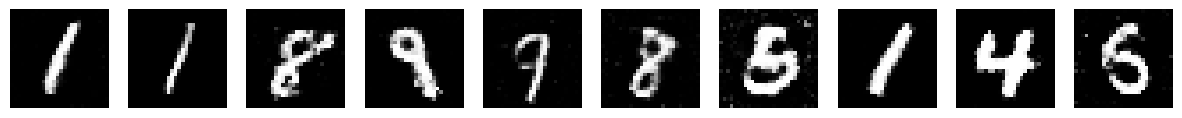

Epoch: 176/200 | Generator Loss: 1.3753205336995724 | Discriminator Loss: 0.4964424945525269


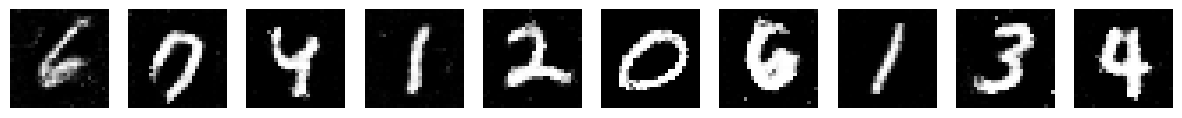

Epoch: 177/200 | Generator Loss: 1.3579699863502974 | Discriminator Loss: 0.49877070815070096


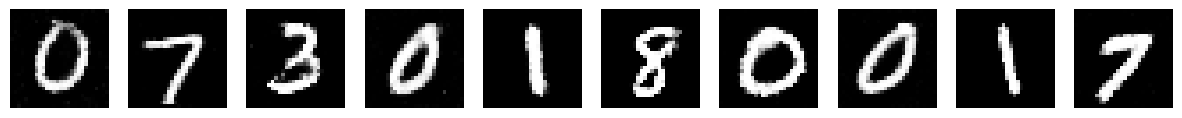

Epoch: 178/200 | Generator Loss: 1.3597920423885907 | Discriminator Loss: 0.49673139064042554


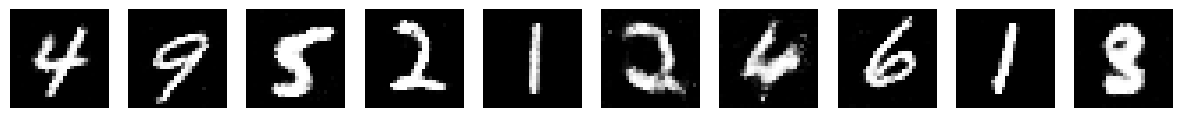

Epoch: 179/200 | Generator Loss: 1.3521806393096696 | Discriminator Loss: 0.49860958033787417


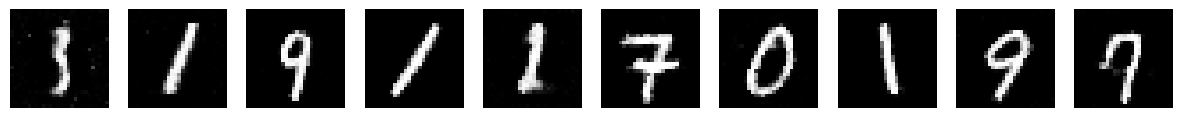

Epoch: 180/200 | Generator Loss: 1.3640733197299657 | Discriminator Loss: 0.495715624869251


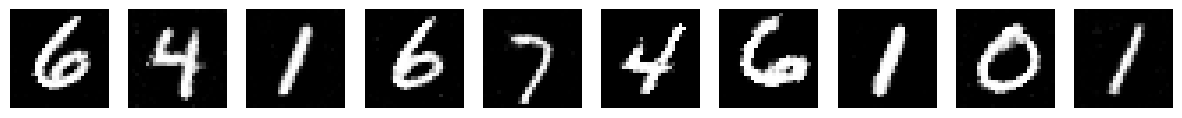

Epoch: 181/200 | Generator Loss: 1.3632727462345604 | Discriminator Loss: 0.4944748412698571


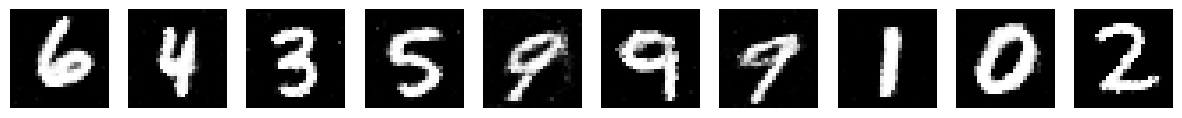

Epoch: 182/200 | Generator Loss: 1.3512742575297731 | Discriminator Loss: 0.49647814874201696


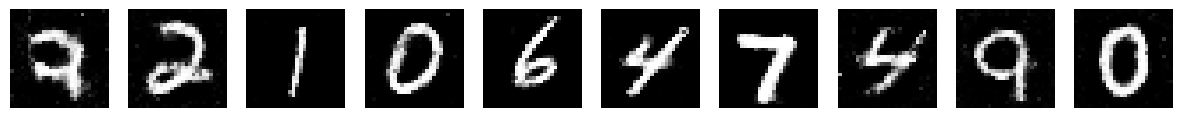

Epoch: 183/200 | Generator Loss: 1.3819062590344882 | Discriminator Loss: 0.4930763571882553


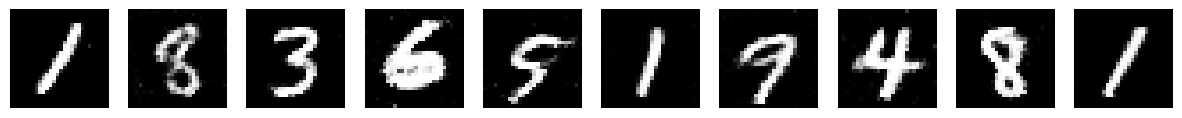

Epoch: 184/200 | Generator Loss: 1.3617910050125772 | Discriminator Loss: 0.49609176906695496


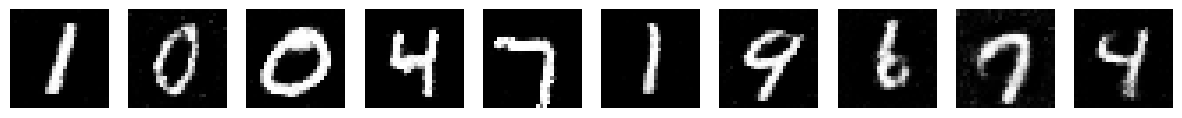

Epoch: 185/200 | Generator Loss: 1.3686633725156154 | Discriminator Loss: 0.49093711833709847


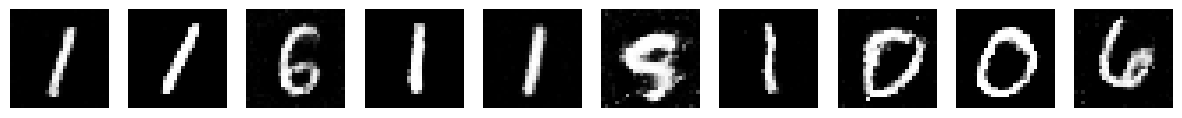

Epoch: 186/200 | Generator Loss: 1.379146831376212 | Discriminator Loss: 0.4919633036737503


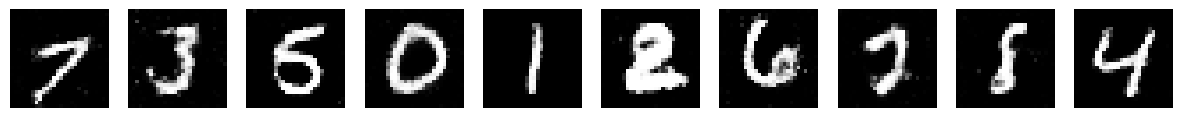

Epoch: 187/200 | Generator Loss: 1.3767953696789772 | Discriminator Loss: 0.4925358906102333


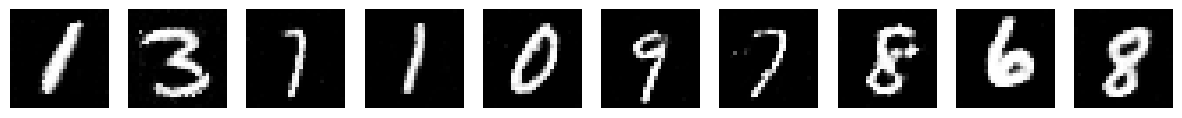

Epoch: 188/200 | Generator Loss: 1.3676191087978988 | Discriminator Loss: 0.4921834781479988


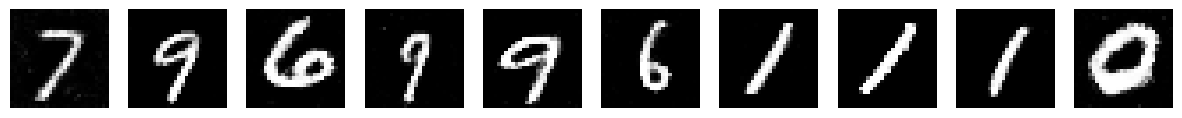

Epoch: 189/200 | Generator Loss: 1.3913674280841721 | Discriminator Loss: 0.488881911168983


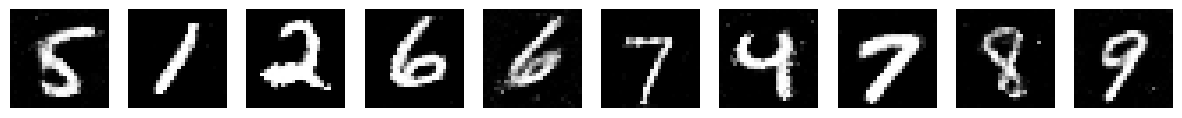

Epoch: 190/200 | Generator Loss: 1.390712728886716 | Discriminator Loss: 0.48830681251310337


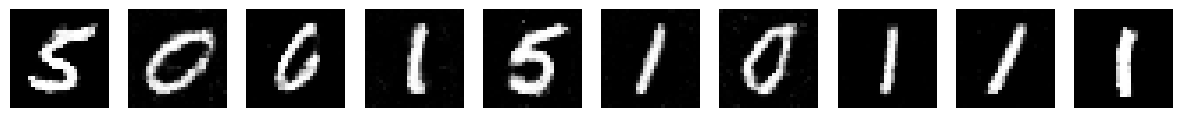

Epoch: 191/200 | Generator Loss: 1.3799185623238082 | Discriminator Loss: 0.4897851751430202


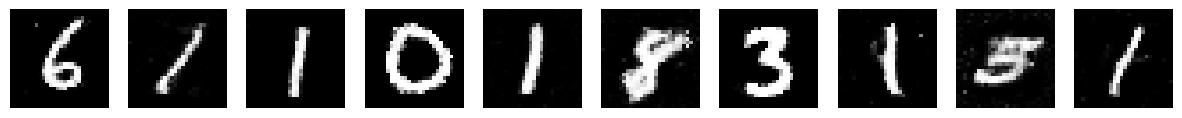

Epoch: 192/200 | Generator Loss: 1.3764564317426702 | Discriminator Loss: 0.49172369744986105


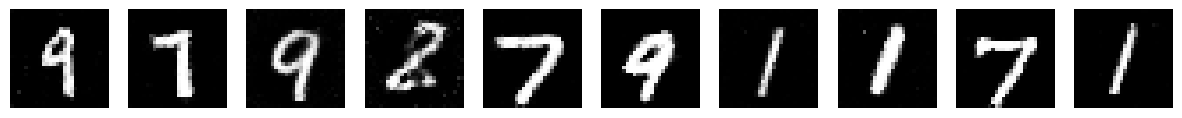

Epoch: 193/200 | Generator Loss: 1.3820073187732493 | Discriminator Loss: 0.48983586241187316


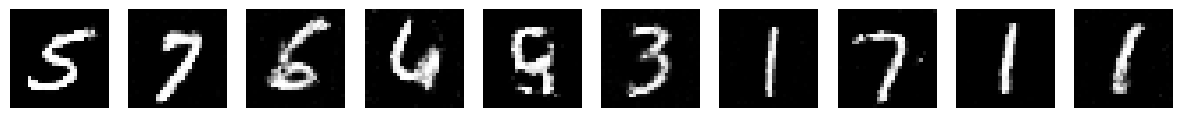

Epoch: 194/200 | Generator Loss: 1.3749741414970935 | Discriminator Loss: 0.49247752355614194


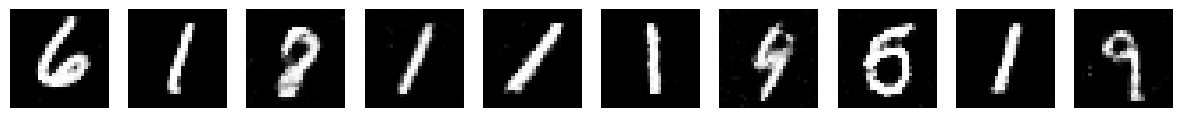

Epoch: 195/200 | Generator Loss: 1.389144490268439 | Discriminator Loss: 0.48975397350945704


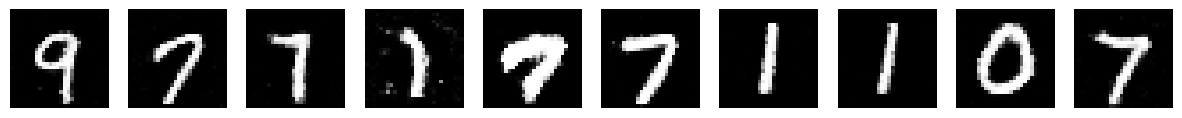

Epoch: 196/200 | Generator Loss: 1.3894740897201017 | Discriminator Loss: 0.4896057044773468


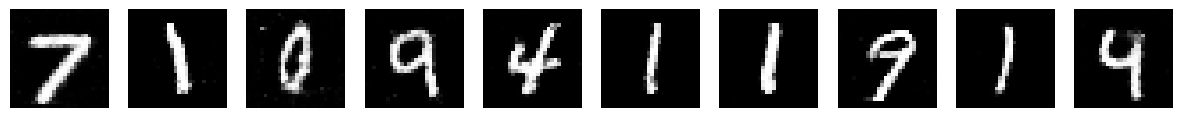

Epoch: 197/200 | Generator Loss: 1.37597336621681 | Discriminator Loss: 0.48956302647143285


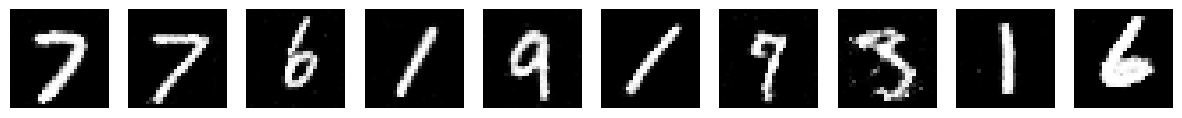

Epoch: 198/200 | Generator Loss: 1.3997877088945303 | Discriminator Loss: 0.49000175497425136


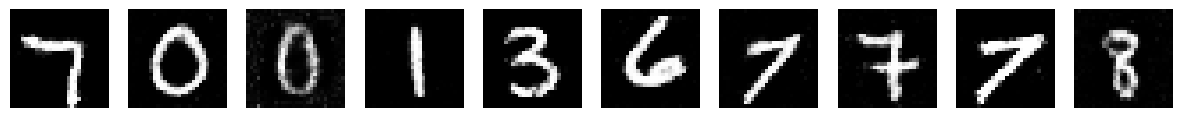

Epoch: 199/200 | Generator Loss: 1.381169361854667 | Discriminator Loss: 0.4899731297482814


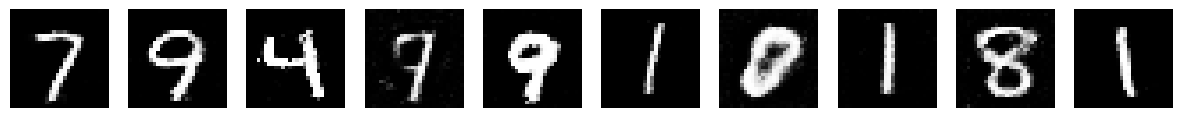

In [5]:

gen_losses, disc_losses = [], []



for epoch in tqdm(range(epochs)):

    generator_epoch_losses = []
    discriminator_epoch_losses = []

    
    for images, _ in trainloader:

        batch_size = images.shape[0]

        images = images.to(device)

        ### Sample noise for Generation ###
        noise = torch.randn(batch_size, latent_dimension, device=device)

        ### Generate Images ###
        generated_imgs = generator(noise)

        ### Create Labels for Discriminator with label smoothing ###
        generated_labels = torch.zeros(batch_size, device=device)
        true_labels = torch.ones(batch_size, device=device)

        ### Concat together Labels and Images ###
        stacked_images = torch.cat((images, generated_imgs.detach()), axis=0)
        stacked_labels = torch.cat((true_labels, generated_labels), axis=0).unsqueeze(-1)

        ### Inference and Update Discriminator ###
        disc_optimizer.zero_grad()
        preds = discriminator(stacked_images)
        discriminator_loss = loss_func(preds, stacked_labels)
        discriminator_epoch_losses.append(discriminator_loss.item())
        discriminator_loss.backward()
        disc_optimizer.step()
        

        ### Create Opposite Labels for Generator Update (All generated images should be predicted as "true" images) ###
        generator_labels = torch.ones(batch_size, device=device).unsqueeze(-1)

        ### Pass generated images to discriminator (pretending they are real) and then backprop loss ###
        gen_optimizer.zero_grad()
        
        discriminator_w_generated_output = discriminator(generated_imgs)
        generator_loss = loss_func(discriminator_w_generated_output, generator_labels)
        generator_epoch_losses.append(generator_loss.item())
        generator_loss.backward()
        gen_optimizer.step()
        

    generator_epoch_losses = np.mean(generator_epoch_losses)
    discriminator_epoch_losses = np.mean(discriminator_epoch_losses)

    print(f"Epoch: {epoch}/{epochs} | Generator Loss: {generator_epoch_losses} | Discriminator Loss: {discriminator_epoch_losses}")

    gen_losses.append(generator_epoch_losses)
    disc_losses.append(discriminator_epoch_losses)

    generator.eval()
    with torch.no_grad():
        noise_sample = torch.randn(10, latent_dimension, device=device)
        generated_imgs = generator(noise_sample).to("cpu")

        fig, ax = plt.subplots(1,10, figsize=(15,5))

        for i in range(10):
            img = (generated_imgs[i].squeeze() + 1)/2
            ax[i].imshow(img.numpy(), cmap="gray")
            ax[i].set_axis_off()

        plt.show()
            
    generator.train()

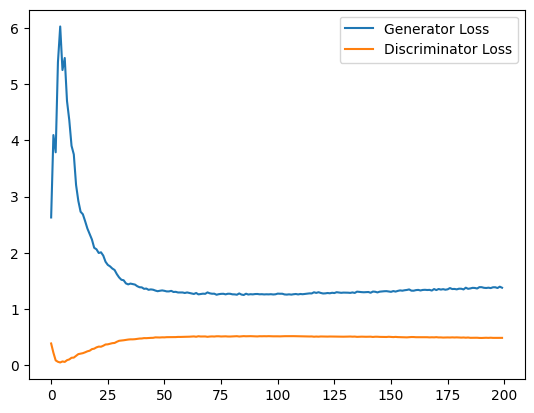

In [6]:
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.legend()
plt.show()

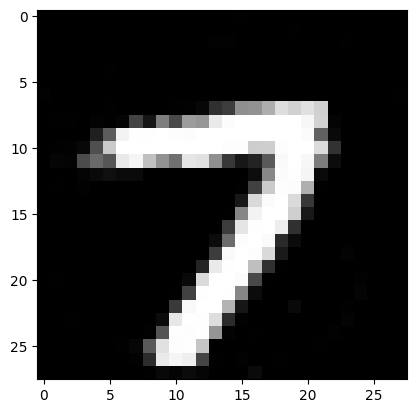

In [175]:

generator.eval()
noise_sample = torch.randn(1, latent_dimension, device=device)
generated_imgs = generator(noise_sample).detach().to("cpu")
generated_imgs = (generated_imgs.squeeze() + 1) / 2
plt.imshow(generated_imgs.numpy(), cmap="gray")
plt.show()